Voy a repetir la misma obtencion de datos que hice para los datos del 2021, pero para los datos del 2022. Asi podre probar el mejor modelo con datos desconocidos.

In [1]:
def algoritmo(df2, fecha, show, parcela):
    diasTotales = 365 + 31
    #from IPython.core.display import display, HTML
    #display(HTML("<style>div.output_scroll { height: 90em; }</style>"))

    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    import datetime

    import warnings
    warnings.filterwarnings("ignore")
    
    borrarDebajo = 0.15
    
    fechas = list()
    fechas2 = list()
    valores = list()
    valores2= list()
    N = int(df2.size / 3) #numero de valores que tenemos para esta parcela

    #Almacenamos los datos originales de la parcela en 'fechas' y 'valores'
    #En 'fechas2' y 'valores2' almacenamos los datos cuyo ndvi esté por encima de 'borrarDebajo'
    for i in range(N):
        data = df2.iloc[i].fecha
        data = str(data)
        #Esto convierte la cadena YYYYMMDD en un tipo de dato fecha
        dt = datetime.datetime.strptime(data, "%Y%m%d")
        dtInt = int(dt.strftime("%j"))
        if int(data) >= 20220000:
            dtInt = dtInt +365
        #Convierto ese tipo de dato fecha en un entero, el dia del año de esa fecha
        #Ej. 20210202 es el 2 de febrero y es el dia 33 del año
        fechas.append(dtInt)
        ndvi = df2.iloc[i].ndvi
        valores.append(ndvi)
        #Solo añado si el valor está por encima de la variable "borrarDebajo"
        if ndvi >= borrarDebajo:
            valores2.append(ndvi)
            fechas2.append(dtInt)

    #Borramos de 'valores2' y 'fechas2' los datos cuyos ndvi sean menores que el dato anterior y al siguiente (valores valle)
    #Ejemplo: si tenemos los valores [3,1,2,4], borramos los valores 1 y 2
    #Si tenemos los valores [3,1,4], borramos el valor 1
    #Borramos los valores valle
    for i in range(len(valores2)-1):
        if i > 0 and i < len(valores2)-1:
            #Si hay 2 valores juntos menores que el anterior y el siguiente, se borran ambos
            if i < (len(valores2) - 2) and valores2[i-1] > valores2[i] and valores2[i-1] > valores2[i+1] and valores2[i+2] > valores2[i] and valores2[i+2] > valores2[i+1]:
                del valores2[i]
                del fechas2[i]
                del valores2[i]
                del fechas2[i]
            #En el caso de que solo haya un minimo entre 2 puntos
            elif valores2[i-1] > valores2[i] and valores2[i+1] > valores2[i]:
                del valores2[i]
                del fechas2[i]        






    #Variables:
    saltoFechas = 10
    saltoFechas2 = 20
    saltoFechas3 = 30
    añadirPorDebajo = 0.4 #antes se llamaba maximoMinimo
    añadirPorEncima = 0.2

    #Añado informacion al principio y final de año si no habia
    if fechas2[0] > 0:
        fechas2.insert(0, 0)
        valores2.insert(0, valores2[0])
    if fechas2[len(fechas2) -1] < diasTotales:
        fechas2.insert(len(fechas2), diasTotales)
        valores2.insert(len(valores2), valores2[len(valores2)-1])


    #Si hay saltos muy grandes sin informacion se trata:
    i = 0
    while i < len(fechas2) - 1: 
        encontrado = False
        #Si el salto es muy grande
        if (fechas2[i+1]-fechas2[i]) >= saltoFechas3 and i+1 != (len(fechas2) -1) and i != 0:
            #buscar maximos locales entre los dos puntos y
            aux1 = 0
            aux2 = 0
            for j in range(len(fechas) - 1):
                if fechas[j] <= fechas2[i] and fechas[j+1] >= fechas2[i]:
                    aux1 = j
                elif fechas[j] <= fechas2[i]  and fechas[j+1] >= fechas2[i]   :
                    aux2 = j
                    break
            j = aux1 + 1
            auxSum = 0
            while (j < aux2):
                if valores[j] > valores[j-1] and valores[j] > valores[j+1]:
                    # y volverlos a añadir segun su valor
                    if (valores2[i] <= 0.6 and valores2[i+1] <=0.6 and valores[j] <= añadirPorDebajo and valores[j] >= añadirPorEncima):
                        fechas2.insert(i+1+ auxSum, fechas[j])
                        valores2.insert(i+1+ auxSum, valores[j])
                        auxSum = auxSum + 1
                        encontrado = True
                j = j + 1



        if encontrado == False:    
            #Si el salto es intermedio
            if (fechas2[i+1]-fechas2[i]) >= saltoFechas2:
                if valores2[i+1] > valores2[i]: #va hacia arriba
                    fechas2.insert(i+1, fechas2[i] + ((fechas2[i+1] - fechas2[i]) / 3)*2)
                    valores2.insert(i+1, valores2[i] + ((valores2[i+1] - valores2[i]) / 3))
                else: #va hacia abajo
                    fechas2.insert(i+1, fechas2[i] + ((fechas2[i+1] - fechas2[i]) / 3))
                    valores2.insert(i+1,  valores2[i+1] + ((valores2[i] - valores2[i+1]) / 3))
            #Si el salto es pequeño
            elif (fechas2[i+1]-fechas2[i]) >= saltoFechas:
                fechas2.insert(i+1, (fechas2[i+1]+fechas2[i])/2)
                valores2.insert(i+1, (valores2[i+1]+valores2[i])/2)
        i = i+1


    #Plot    
    from scipy.interpolate import make_interp_spline
    from scipy.interpolate import interp1d

    #Esto crea una linea de <diasTotales> puntos que pasa por todos los puntos que teniamos
    X_Y_Spline = make_interp_spline(fechas2,valores2)        
    X = np.linspace(0, diasTotales, diasTotales)
    Y = X_Y_Spline(X)

    dt = datetime.datetime.strptime(fecha, "%Y%m%d")
    aux = int(dt.strftime("%j"))
    
    if (show):
        plt.figure(figsize=(17,5))
        plt.title('parcela: '+ parcela)
        plt.plot(fechas, valores,'r-')

        plt.xticks(np.arange(0, diasTotales,10))

        plt.plot(X, Y, 'b-')
        plt.scatter(fechas, valores, c=valores, cmap='Set2')

        #Dibujar las lineas verticales asociadas a las fechas de recepcion
        #for recepcion in recepciones:
        #    if recepcion[0] == parcela:
        #        for aux in recepcion[1]:
        #            dt = datetime.datetime.strptime(aux, "%Y%m%d")
        #            aux2 = int(dt.strftime("%j"))
        #            plt.axvline(x=(aux2))  
        #        break

        #dt = datetime.datetime.strptime(fecha, "%Y%m%d")
        #aux = int(dt.strftime("%j"))
        plt.axvline(x=(aux))  



        plt.xlabel("X")
        plt.ylabel("Y")
        plt.ylim([0, 1])
        plt.legend(["puntos originales","puntos modificados"])
        plt.show()
        
    return [Y, aux]

def obtenerColumnas():
    columnas = list()
    columnas.append('parcela')
    columnas.append('dia')
    columnas.append('pendiente dia -15')
    columnas.append('pendiente dia -10')
    columnas.append('pendiente dia -5')
    columnas.append('ndvi')
    columnas.append('recogido')
    
    return columnas

def inicializarDataframeIA(columnas):
    import pandas as pd
    df_ia = pd.DataFrame(columns=columnas())
    
    return df_ia

def obtenerParcelasConUnaRecepcion(PARCELASMAIZ20212022CONFECHAS):
    import pandas as pd

    dfFechas = pd.read_csv(PARCELASMAIZ20212022CONFECHAS)
    
    freq = dfFechas['PAC'].value_counts()
    items = freq[freq==1].index
    only_1_reception = dfFechas[dfFechas['PAC'].isin(items)]

    newPac = only_1_reception["PAC"].str.replace(":", "_")
    newDate = only_1_reception["Fecha de carga"].str.replace("-", "")

    only_1_reception["PAC"] = newPac
    only_1_reception["Fecha de carga"] = newDate
    only_1_reception['Fecha de carga'] = only_1_reception['Fecha de carga'].apply(str)
    
    return only_1_reception

def añadirADataframe(parcela, diaDeCarga, valoresDias, columnas, df,diasPendiente, diasMargen):
    import pandas as pd
    for i in range(len(valoresDias)):
        if ((i - (diasPendiente[0])) >= 0 and (i+1) - diaDeCarga > -15 and (i+1) - diaDeCarga <= 5  ):
            
            lista = list()
            lista.append(parcela)
            lista.append(i + 1)
            for j in diasPendiente:
                lista.append((valoresDias[i - j] - valoresDias[i])/j)
                
            lista.append(valoresDias[i])
            if ((diaDeCarga - (i + 1)) <= diasMargen and (diaDeCarga - (i + 1)) >= 0):
                lista.append(1)
            else:
                lista.append(0)

            dfAux = pd.DataFrame([lista], columns=columnas(), index=[len(df)])
            df = df.append(dfAux)
    
    
    return df


def obtenerDatosEntrenables(datosNoEntrenables2122, PARCELASMAIZ20212022CONFECHAS):
    import pandas as pd
    dfFechas = obtenerParcelasConUnaRecepcion(PARCELASMAIZ20212022CONFECHAS)
    
    
    dfDatos = pd.read_csv(datosNoEntrenables2122)
    dfDatos = dfDatos.sort_values(by=["fecha","parcela"], ascending=True)
    
    parcelasQueTengo = dfDatos["parcela"].unique()
    parcelasConUnaRecepcion = dfFechas["PAC"].unique()

    df_ndvi_of_only_1_reception = dfDatos[dfDatos.parcela.isin(dfFechas["PAC"].unique())]
    parcelas = df_ndvi_of_only_1_reception['parcela'].unique()
    
    
    df = inicializarDataframeIA(obtenerColumnas)
    i = 0
    j = len(parcelas)
    diaPrimeraRecepcion = [15,10,5]
    diaMargen = 4
    
    
    for parcela in parcelas:

        df2 = df_ndvi_of_only_1_reception.loc[df_ndvi_of_only_1_reception['parcela'] == parcela]
        df2 = df2.drop_duplicates()
        if (not df2.empty):
            fecha_df = dfFechas.loc[dfFechas["PAC"] == parcela] 
            fecha = fecha_df.iloc[0]["Fecha de carga"]
            X, dia_recepcion = algoritmo(df2, fecha, True, parcela)
            if (dia_recepcion > diaPrimeraRecepcion[0]):
                df = añadirADataframe(parcela, dia_recepcion, X, obtenerColumnas, df, diaPrimeraRecepcion, diaMargen)
            i = i + 1
            print(str(i) + "/" + str(j)) 
        else:
            j = j - 1
        

    return df

def separarTrainTest(dataframe):
    parcelas = dataframe['parcela'].unique()
    N = len(parcelas)

    #si hay 2 recintos de la misma zona uno lo meto a test
    test= list()
    train = list(parcelas)
    contador = 1
    for i in range(N):
        parcelaAnterior = parcelas[i - 1].split('_')
        aux = ''
        for j in range(5):
            aux = aux + parcelaAnterior[j] + '_'


        if parcelas[i].startswith(aux):
            test.append(parcelas[i])
            train.remove(parcelas[i])
            if len(test) >= N * 0.1:
                break

    dataframeTrain = dataframe[dataframe['parcela'].isin(train)]
    dataframeTest =  dataframe[dataframe['parcela'].isin(test)]
    
    return [dataframeTrain, dataframeTest]

def obtenerModelo(dataframeTrain, regularizacion=1):
    # Perceptron de un solo nivel
    from keras.layers import Dense
    from keras.regularizers import l2
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import RMSprop, Adam, SGD
    from keras.callbacks import EarlyStopping
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers

    
    X = np.asarray(dataframeTrain.drop(columns=['parcela','dia','recogido'])).astype(np.float32)
    
    normalizer = layers.Normalization()
    normalizer.adapt(X)
    
    n = dataframeTrain.drop(columns=['parcela','dia','recogido']).shape[1]

    model = Sequential()
    
    model.add(normalizer)
    #,kernel_initializer=initializer
    #model.add(Dense(n**3, activation='relu', input_shape=(n,), kernel_regularizer=l2(regularizacion)))
    #añadir capa
    model.add(Dense(n**2, activation='relu', input_shape=(n,), kernel_regularizer=l2(regularizacion)))
    model.add(Dense(n, activation='relu', kernel_regularizer=l2(regularizacion)))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(regularizacion)))
    #
    model.compile(loss='binary_crossentropy', optimizer=Adam(),  metrics=[tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', threshold=0.6), keras.metrics.Recall(name='recall', threshold = 0.6)])
    model.summary()
    
    return model

def obtenerModelo3(dataframeTrain, regularizacion=1):
    # Perceptron de un solo nivel
    from keras.layers import Dense
    from keras.regularizers import l2
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import RMSprop, Adam, SGD
    from keras.callbacks import EarlyStopping
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers

    
    X = np.asarray(dataframeTrain.drop(columns=['parcela','dia','recogido'])).astype(np.float32)
    
    normalizer = layers.Normalization()
    normalizer.adapt(X)
    
    n = dataframeTrain.drop(columns=['parcela','dia','recogido']).shape[1]

    model = Sequential()
    
    model.add(normalizer)
    #,kernel_initializer=initializer
    #model.add(Dense(n**3, activation='relu', input_shape=(n,), kernel_regularizer=l2(regularizacion)))
    #añadir capa
    #model.add(Dense(n**2, activation='relu', input_shape=(n,), kernel_regularizer=l2(regularizacion)))
    model.add(Dense(n, activation='relu',input_shape=(n,), kernel_regularizer=l2(regularizacion)))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(regularizacion)))
    #
    model.compile(loss='binary_crossentropy', optimizer=Adam(),  metrics=[tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', threshold=0.6), keras.metrics.Recall(name='recall')])
    model.summary()
    
    return model

def obtenerModelo4(dataframeTrain, regularizacion=1):
    # Perceptron de un solo nivel
    from keras.layers import Dense
    from keras.regularizers import l2
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import RMSprop, Adam, SGD
    from keras.callbacks import EarlyStopping
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers

    
    X = np.asarray(dataframeTrain.drop(columns=['parcela','dia','recogido'])).astype(np.float32)
    
    normalizer = layers.Normalization()
    normalizer.adapt(X)
    
    n = dataframeTrain.drop(columns=['parcela','dia','recogido']).shape[1]

    model = Sequential()
    
    model.add(normalizer)
    #,kernel_initializer=initializer
    model.add(Dense(n**3, activation='relu', input_shape=(n,), kernel_regularizer=l2(regularizacion)))
    #añadir capa
    model.add(Dense(n**2, activation='relu',  kernel_regularizer=l2(regularizacion)))
    model.add(Dense(n, activation='relu', kernel_regularizer=l2(regularizacion)))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(regularizacion)))
    #
    model.compile(loss='binary_crossentropy', optimizer=Adam(),  metrics=[tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', threshold=0.6), keras.metrics.Recall(name='recall', threshold = 0.6)])
    model.summary()
    
    return model

def obtenerModelo5(dataframeTrain, regularizacion=1):
    # Perceptron de un solo nivel
    from keras.layers import Dense
    from keras.regularizers import l2
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import RMSprop, Adam, SGD
    from keras.callbacks import EarlyStopping
    from tensorflow.keras.layers import Dropout
    from tensorflow.keras.constraints import MaxNorm
    from tensorflow.keras.optimizers import SGD
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers

    
    X = np.asarray(dataframeTrain.drop(columns=['parcela','dia','recogido'])).astype(np.float32)
    
    normalizer = layers.Normalization()
    normalizer.adapt(X)
    
    n = dataframeTrain.drop(columns=['parcela','dia','recogido']).shape[1]

    model = Sequential()
    
    model.add(normalizer)
    #,kernel_initializer=initializer
    # Compile model
    #añadir capa
    model.add(Dense(n, activation='relu', input_shape=(n,), kernel_constraint=MaxNorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(4, activation='relu', kernel_constraint=MaxNorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    #
    sgd = SGD(learning_rate=0.1, momentum=0.9)
    model.compile(loss='binary_crossentropy', optimizer=sgd,  metrics=[tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', threshold=0.6), keras.metrics.Recall(name='recall')])
    model.summary()
    
    return model

def obtenerModelo2(dataframeTrain):
    # Perceptron de un solo nivel
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import RMSprop, Adam, SGD
    from keras.callbacks import EarlyStopping
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers

    X = np.asarray(dataframeTrain.drop(columns=['parcela','dia','recogido'])).astype(np.float32)
    normalizer = layers.Normalization()
    normalizer.adapt(X) 
    
    model = Sequential()
    
    #model.add(normalizer)
    
    model.add(Dense(4096, kernel_initializer='normal',input_dim = dataframeTrain.drop(columns=['parcela','dia','recogido']).shape[1], activation='sigmoid'))

    # The Hidden Layers :
    model.add(Dense(2048 ,activation='softmax'))
    model.add(Dense(1024 ,activation='sigmoid'))
    model.add(Dense(512,activation='relu'))
    model.add(Dense(256,activation='softmax'))
    model.add(Dense(128,activation='sigmoid'))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(32,activation='softmax'))
    model.add(Dense(16,activation='sigmoid'))
    model.add(Dense(8,activation='relu'))
    model.add(Dense(4,activation='softmax'))
    
    model.add(Dense(2, activation='softmax'))
    #
    model.compile(loss='categorical_crossentropy', optimizer=Adam(),  metrics=['accuracy'])
    model.summary()
    
    return model

def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    fig, axs = plt.subplots(1, 2,  figsize=(12, 6))
    for l in loss_list:
        axs[0].plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        axs[0].plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    axs[0].set(title='Loss', xlabel='Epochs', ylabel='Loss')
    axs[0].grid()
    axs[0].legend()
    
    ## Accuracy
    for l in acc_list:
        axs[1].plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        axs[1].plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    axs[1].set(title='Accuracy', xlabel='Epochs', ylabel='Accuracy')
    axs[1].grid()
    axs[1].legend()
    plt.show()
    
def anyadirUnos(df):
    df['unos'] = [1]*len(df)
    
def RecepcionToBool(recogido):
    aux = np.zeros(2)
    aux[recogido] = 1
    return aux
            
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import RMSprop, Adam, SGD
    from keras.callbacks import EarlyStopping
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    #plt.tight_layout()

def plot_mnist_confusion_matrix(y_test, y_pred, normalize=False):
    from sklearn.metrics import confusion_matrix
    
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import RMSprop, Adam, SGD
    from keras.callbacks import EarlyStopping
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers
    umbral = 0.01
    
    y_tst = np.zeros(len(y_test))
    for i in range(len(y_test) - 1):
        #if y_test[i][1] >= umbral:
        #    y_tst[i] = 1
        y_tst[i] = np.argmax(y_test[i])
    #y_tst = [np.argmax(y) for y in y_test]
    
    y_prd = np.zeros(len(y_pred))
    for i in range(len(y_pred) - 1):
        #if y_pred[i][1] >= umbral:
        #    y_prd[i] = 1
        y_prd[i] = np.argmax(y_pred[i])
    #y_prd = [np.argmax(y) for y in y_pred]

    cnf_matrix = confusion_matrix(y_tst, y_prd)
    
    yprueba = list()
    for y in y_tst:
        yprueba.append(y)
    for y in y_prd:
        yprueba.append(y)
    class_names=np.unique(yprueba)
    print(class_names)
    plt.figure(figsize=(20,20))
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          normalize=normalize)
    
def quitarDatosMalos(df):
    #QUITA LAS PARCELAS QUE NO TENGAN 20 DIAS DE DATOS
    parcelasAQuitar = list()
    parcelas = df['parcela'].unique()
    for parcela in parcelas:
        if len(df.loc[df['parcela'] == parcela]) != 20:
            parcelasAQuitar.append(parcela)
    
    df = df[~df['parcela'].isin(parcelasAQuitar)]
    return df
    
def anyadirRelacionesParametros2(df):
    columnas = df.shape[1]
    for i in range(columnas):
        for j in range(columnas):
            if i < j:
                nombreColumna = 'col ' + str(i+1) + ' * col ' + str(j+1)
                df[nombreColumna] = df.iloc[:,i] * df.iloc[:,j]
                
    return df
    
def anyadirRelacionesParametros(df, listaColumnas = ['parcela','dia','recogido','ndvi']):
    aux = pd.DataFrame()
    for i in listaColumnas:
        aux[i] = df[i]
        df = df.drop(columns=[i])
        
    df = anyadirRelacionesParametros2(df)
    for i in listaColumnas:
        df[i] = aux[i]
    return df
    
def entrenarModelo(model, dataframeTrain, dataframeTest, batch_size, epochs, callbacks_list):
    def RecepcionToBool(recogido):
        aux = np.zeros(2)
        aux[recogido] = 1
        return aux

    #DATA TRAINING   
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers
    N = len(dataframeTrain)


    verbose = True
    t0 = time.perf_counter()
    X = np.asarray(dataframeTrain.drop(columns=['parcela','dia','recogido'])).astype(np.float32)
    y = np.asarray(dataframeTrain[["recogido"]]).astype(np.float32)
    
    #DATA TESTING
    N = len(dataframeTest)

    Xtest = np.asarray(dataframeTest.drop(columns=['parcela','dia','recogido'])).astype(np.float32)
    ytest = np.asarray(dataframeTest[["recogido"]]).astype(np.float32)
    


    history = model.fit(X, y,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=False, 
                        callbacks=callbacks_list,
                       validation_data=(Xtest,ytest))

    #model.predict(X_cv)

    train_time = time.perf_counter() - t0
    print('%s %.3f%s' %  ('Training time: ', train_time, 's') )
    plot_history(history)
    
def predecirYMostrarMatrizConfusion(df,model,pesos, umbral = 0.6):
    df = df.reset_index()
    df = df.drop(columns=['index'])
    X = df.drop(columns=['parcela','dia','recogido'])
    y = df['recogido']
    
    X=np.asarray(X).astype(np.float)

    y=np.asarray(y).astype(np.float)
    
    model.load_weights(pesos)
    
    
    
    y_pred = model.predict(X, verbose=True)
    
    tp = 0
    tn = 0
    fp = 0
    fn = 0

    for i in range(len(y_pred)):
        if y_pred[i] >= umbral and y[i] == 1:
            tp = tp + 1
        elif y_pred[i] >= umbral and y[i] == 0:
            fp = fp + 1
        elif y_pred[i] < umbral and y[i] == 1:
            fn = fn + 1
        else:
            tn = tn + 1


    test_score = (tp + tn)/ len(X)
    print('%s %2.2f%s' % ('Accuracy test:  ', 100*test_score, '%'))

    import seaborn as sn
    import pandas as pd
    import matplotlib.pyplot as plt
    ind = np.asarray([0.0,1.0]).astype(np.float32)
    mat = np.asarray([[tn, fp], [fn, tp]]).astype(np.int32)
    plt.figure(figsize=(20,20))
    plot_confusion_matrix(mat, classes=ind,
                              normalize=False)



# Define la función de poda
def prune_low_weights(model, pruning_threshold):
    from keras import backend as K
    for layer in model.layers:
        if hasattr(layer, 'kernel_regularizer'):
            weights = layer.get_weights()[0]  # Obtiene los pesos de la capa
            mask = K.abs(weights) > pruning_threshold  # Aplica el umbral
            weights *= mask  # Poda los pesos por debajo del umbral
            layer.set_weights([weights])  # Establece los pesos podados en la capa
            
def parcelasConAciertos(dataframe,model,  umbral = 0.6, verbose=1, XGBoost = False, LGBM= False):
    import lightgbm as lgb
    import xgboost as xgb
    dataframeRecogidoUno = dataframe.loc[dataframe['recogido'] == 1]
    parcelasAObservar = dataframe['parcela'].unique()
    parcelasSinResultado = list(dataframe['parcela'].unique())
    if verbose == 1:
        print(len(parcelasSinResultado))
        print("hay ", str(len(parcelasAObservar)), " parcelas a observar")
        print('------------------')
    cantidad = 0
    for parcela in parcelasAObservar:
        unoAcertado = False
        datos = dataframe.loc[dataframe['parcela'] == parcela]
        dias = dataframeRecogidoUno.loc[dataframeRecogidoUno['parcela'] == parcela]['dia']
        if verbose == 1:
            print(parcela, 'dias que deberia dar 1 la prediccion:')
            print(dias)
        Xtest = np.asarray(dataframe.loc[dataframe['parcela'] == parcela].drop(columns=['parcela','dia','recogido'])).astype(np.float32)
        ytest = np.asarray(dataframe.loc[dataframe['parcela'] == parcela][["recogido"]]).astype(np.float32)
        
        # preparar datos de xgboost
        if XGBoost == True:
            X_test = pd.DataFrame(Xtest, columns=dataframe.drop(columns=['recogido','parcela','dia']).columns)
            Xtest = xgb.DMatrix(X_test, label=ytest)
        # preparar datos de lgbm
        elif LGBM == True:
            X_test = pd.DataFrame(Xtest, columns=dataframe.drop(columns=['recogido','parcela','dia']).columns)
            Xtest = X_test.values
        
        # predicciones
        if hasattr(model, 'predict_proba'):
            ypred = model.predict_proba(Xtest)[:,1]
        else:
            if 'verbose' in model.predict.__code__.co_varnames:
                ypred = model.predict(Xtest, verbose=verbose)
            else:
                ypred = model.predict(Xtest)
            
            
        if verbose == 1:
            print("dias que ha dado 1 la prediccion: ")
        for i in range(len(ypred)):
            if ypred[i] >= umbral:
                if verbose == 1:
                    print('dia: ', datos.iloc[i]['dia'])
                if ytest[i] == 1 and unoAcertado == False:
                    cantidad = cantidad + 1
                    unoAcertado = True
                    
                    
        if (unoAcertado == True):
            if verbose == 1:
                print("ha acertado por lo menos un 1 de los que deberia")
            parcelasSinResultado.remove(parcela)

        if verbose == 1:
            print('------------------')

    print('Parcelas con acierto: ',cantidad, "de", str(len(parcelasAObservar)) , " ", "{:.2%}".format(cantidad/len(parcelasAObservar)))
    return [parcelasAObservar, parcelasSinResultado]
    
    
def obtenerMejorModelo(directory_init = ''):
    import os
    import ipynbname
    if directory_init == '':
        directory = ipynbname.name()
    else:
        directory = directory_init
    baccuracyMax = 0
    baccuracyMaxFile = ''
    val_baccuracyMax = 0
    val_baccuracyMaxFile = ''
    recallMax = 0
    recallMaxFile = ''
    val_recallMax = 0
    val_recallMaxFile = ''
    # iterate over files in
    # that directory
    for subdirectory in os.listdir(directory):
        f = os.path.join(directory, subdirectory)
        # checking if it is a file
        for filename in os.listdir(f):
            campos = filename.split('-')
            f1 = os.path.join(f, filename)
            if (len(campos)) == 5:
                if (campos[3] == 'binary_accuracy' and float(campos[4][:len(campos[4])-5]) > float(baccuracyMax)):
                    baccuracyMax = float(campos[4][:len(campos[4])-5])
                    baccuracyMaxFile = f1
                if (campos[3] == 'val_binary_accuracy' and float(campos[4][:len(campos[4])-5]) > float(val_baccuracyMax)):
                    val_baccuracyMax = float(campos[4][:len(campos[4])-5])
                    val_baccuracyMaxFile = f1
                if (campos[3] == 'recall' and float(campos[4][:len(campos[4])-5]) > float(recallMax)):
                    recallMax = float(campos[4][:len(campos[4])-5])
                    recallMaxFile = f1
                if (campos[3] == 'val_recall' and float(campos[4][:len(campos[4])-5]) > float(val_recallMax)):
                    val_recallMax = float(campos[4][:len(campos[4])-5])
                    val_recallMaxFile = f1

    print("Mejor binary_accuracy: ", baccuracyMax)
    print(baccuracyMaxFile)
    print("Mejor val_binary_accuracy: ", val_baccuracyMax)
    print(val_baccuracyMaxFile)
    print("Mejor recall: ", recallMax)
    print(recallMaxFile)
    print("Mejor val_recall: ", val_recallMax)
    print(val_recallMaxFile)


In [2]:
def mostrarParcelasSinAciertos(parcelasAObservar):

    def algoritmo(df2, fecha, show, tp, fp):

        #from IPython.core.display import display, HTML
        #display(HTML("<style>div.output_scroll { height: 90em; }</style>"))

        import pandas as pd
        import matplotlib.pyplot as plt
        import numpy as np
        import datetime

        import warnings
        warnings.filterwarnings("ignore")

        borrarDebajo = 0.15

        fechas = list()
        fechas2 = list()
        valores = list()
        valores2= list()
        N = int(df2.size / 3) #numero de valores que tenemos para esta parcela

        #Almacenamos los datos originales de la parcela en 'fechas' y 'valores'
        #En 'fechas2' y 'valores2' almacenamos los datos cuyo ndvi esté por encima de 'borrarDebajo'
        for i in range(N):
            data = df2.iloc[i].fecha
            data = str(data)
            #Esto convierte la cadena YYYYMMDD en un tipo de dato fecha
            dt = datetime.datetime.strptime(data, "%Y%m%d")
            #Convierto ese tipo de dato fecha en un entero, el dia del año de esa fecha
            #Ej. 20210202 es el 2 de febrero y es el dia 33 del año
            fechas.append(int(dt.strftime("%j")))
            ndvi = df2.iloc[i].ndvi
            valores.append(ndvi)
            #Solo añado si el valor está por encima de la variable "borrarDebajo"
            if ndvi >= borrarDebajo:
                valores2.append(ndvi)
                fechas2.append(int(dt.strftime("%j")))

        #Borramos de 'valores2' y 'fechas2' los datos cuyos ndvi sean menores que el dato anterior y al siguiente (valores valle)
        #Ejemplo: si tenemos los valores [3,1,2,4], borramos los valores 1 y 2
        #Si tenemos los valores [3,1,4], borramos el valor 1
        #Borramos los valores valle
        for i in range(len(valores2)-1):
            if i > 0 and i < len(valores2)-1:
                #Si hay 2 valores juntos menores que el anterior y el siguiente, se borran ambos
                if i < (len(valores2) - 2) and valores2[i-1] > valores2[i] and valores2[i-1] > valores2[i+1] and valores2[i+2] > valores2[i] and valores2[i+2] > valores2[i+1]:
                    del valores2[i]
                    del fechas2[i]
                    del valores2[i]
                    del fechas2[i]
                #En el caso de que solo haya un minimo entre 2 puntos
                elif valores2[i-1] > valores2[i] and valores2[i+1] > valores2[i]:
                    del valores2[i]
                    del fechas2[i]        






        #Variables:
        saltoFechas = 10
        saltoFechas2 = 20
        saltoFechas3 = 30
        añadirPorDebajo = 0.4 #antes se llamaba maximoMinimo
        añadirPorEncima = 0.2

        #Añado informacion al principio y final de año si no habia
        if fechas2[0] > 0:
            fechas2.insert(0, 0)
            valores2.insert(0, valores2[0])
        if fechas2[len(fechas2) -1] < 365:
            fechas2.insert(len(fechas2), 365)
            valores2.insert(len(valores2), valores2[len(valores2)-1])


        #Si hay saltos muy grandes sin informacion se trata:
        i = 0
        while i < len(fechas2) - 1: 
            encontrado = False
            #Si el salto es muy grande
            if (fechas2[i+1]-fechas2[i]) >= saltoFechas3 and i+1 != (len(fechas2) -1) and i != 0:
                #buscar maximos locales entre los dos puntos y
                aux1 = 0
                aux2 = 0
                for j in range(len(fechas) - 1):
                    if fechas[j] <= fechas2[i] and fechas[j+1] >= fechas2[i]:
                        aux1 = j
                    elif fechas[j] <= fechas2[i]  and fechas[j+1] >= fechas2[i]   :
                        aux2 = j
                        break
                j = aux1 + 1
                auxSum = 0
                while (j < aux2):
                    if valores[j] > valores[j-1] and valores[j] > valores[j+1]:
                        # y volverlos a añadir segun su valor
                        if (valores2[i] <= 0.6 and valores2[i+1] <=0.6 and valores[j] <= añadirPorDebajo and valores[j] >= añadirPorEncima):
                            fechas2.insert(i+1+ auxSum, fechas[j])
                            valores2.insert(i+1+ auxSum, valores[j])
                            auxSum = auxSum + 1
                            encontrado = True
                    j = j + 1



            if encontrado == False:    
                #Si el salto es intermedio
                if (fechas2[i+1]-fechas2[i]) >= saltoFechas2:
                    if valores2[i+1] > valores2[i]: #va hacia arriba
                        fechas2.insert(i+1, fechas2[i] + ((fechas2[i+1] - fechas2[i]) / 3)*2)
                        valores2.insert(i+1, valores2[i] + ((valores2[i+1] - valores2[i]) / 3))
                    else: #va hacia abajo
                        fechas2.insert(i+1, fechas2[i] + ((fechas2[i+1] - fechas2[i]) / 3))
                        valores2.insert(i+1,  valores2[i+1] + ((valores2[i] - valores2[i+1]) / 3))
                #Si el salto es pequeño
                elif (fechas2[i+1]-fechas2[i]) >= saltoFechas:
                    fechas2.insert(i+1, (fechas2[i+1]+fechas2[i])/2)
                    valores2.insert(i+1, (valores2[i+1]+valores2[i])/2)
            i = i+1


        #Plot    
        from scipy.interpolate import make_interp_spline
        from scipy.interpolate import interp1d

        #Esto crea una linea de 365 puntos que pasa por todos los puntos que teniamos
        X_Y_Spline = make_interp_spline(fechas2,valores2)        
        X = np.linspace(0, 365, 365)
        Y = X_Y_Spline(X)

        dt = datetime.datetime.strptime(fecha, "%Y%m%d")
        aux = int(dt.strftime("%j"))

        if (show):
            plt.figure(figsize=(17,5))
            plt.title('parcela: '+ parcela)
            plt.plot(fechas, valores,'r-')

            plt.xticks(np.arange(0, 365,10))

            plt.plot(X, Y, 'b-')
            plt.scatter(fechas, valores, c=valores, cmap='Set2')

            #Dibujar las lineas verticales asociadas a las fechas de recepcion
            #for recepcion in recepciones:
            #    if recepcion[0] == parcela:
            #        for aux in recepcion[1]:
            #            dt = datetime.datetime.strptime(aux, "%Y%m%d")
            #            aux2 = int(dt.strftime("%j"))
            #            plt.axvline(x=(aux2))  
            #        break

            #dt = datetime.datetime.strptime(fecha, "%Y%m%d")
            #aux = int(dt.strftime("%j"))
            plt.axvline(x=(aux), linewidth=2, color='black') 
            [plt.axvline(_x, linewidth=1, color='r') for _x in fp]
            [plt.axvline(_x, linewidth=1, color='g') for _x in tp]







            plt.xlabel("X")
            plt.ylabel("Y")
            plt.ylim([0, 1])
            plt.legend(["puntos originales","puntos modificados","recepcion", "falsos positivo"])
            plt.show()

        return [Y, aux]

    import pandas as pd
    import numpy as np

    dfFechas = pd.read_csv('PARCELAS-MAIZ-2021-2022-CON-FECHAS.csv')

    freq = dfFechas['PAC'].value_counts()
    items = freq[freq==1].index
    only_1_reception = dfFechas[dfFechas['PAC'].isin(items)]

    newPac = only_1_reception["PAC"].str.replace(":", "_")
    newDate = only_1_reception["Fecha de carga"].str.replace("-", "")

    only_1_reception["PAC"] = newPac
    only_1_reception["Fecha de carga"] = newDate
    only_1_reception['Fecha de carga'] = only_1_reception['Fecha de carga'].apply(str)

    df = pd.read_csv('TODOSLOSRECINTOS.csv')

    #Ordeno por fecha y parcela
    sorted_df = df.sort_values(by=["fecha","parcela"], ascending=True)
    sorted_df = sorted_df.drop(columns=['Unnamed: 0'])
    parcelasQueTengo = sorted_df["parcela"].unique()
    parcelasConUnaRecepcion = only_1_reception["PAC"].unique()

    df_ndvi_of_only_1_reception = sorted_df[sorted_df.parcela.isin(only_1_reception["PAC"].unique())]

    dias1 = 7
    dias2 = 180


    i = 0
    #parcelas = df_ndvi_of_only_1_reception['parcela'].unique()
    parcelas = parcelasAObservar
    for parcela in parcelas:
        df2 = df_ndvi_of_only_1_reception.loc[df_ndvi_of_only_1_reception['parcela'] == parcela]
        df2 = df2.drop_duplicates()
        if (not df2.empty):
            fecha_df = only_1_reception.loc[only_1_reception["PAC"] == parcela] 
            fecha = fecha_df.iloc[0]["Fecha de carga"]

            datos = dataframeAux.loc[dataframeAux['parcela'] == parcela]
            dias = dataframeDias.loc[dataframeDias['parcela'] == parcela]['dia']
            #print('------------------')
            #print(parcela, 'dias:')
            tp = list(dias)
            #print(dias)
            Xtest = np.asarray(dataframeAux.loc[dataframeAux['parcela'] == parcela].drop(columns=['parcela','dia','recogido'])).astype(np.float32)
            ytest = np.asarray(dataframeAux.loc[dataframeAux['parcela'] == parcela][["recogido"]]).astype(np.float32)
            ypred = model.predict(Xtest, verbose=0)
            fp = list()
            for i in range(len(ypred)):
                if ypred[i] >= 0.6:
                    fp.append(datos.iloc[i]['dia'])


            X, dia_recepcion = algoritmo(df2, fecha, True, tp, fp)

            i = i + 1





def mostrarParcelasConAciertos(parcelasAObservar):
    def intersection(lst1, lst2):
                lst3 = [value for value in lst1 if value in lst2]
                return lst3
    def algoritmo(df2, fecha, show, tp, fp):

        #from IPython.core.display import display, HTML
        #display(HTML("<style>div.output_scroll { height: 90em; }</style>"))

        import pandas as pd
        import matplotlib.pyplot as plt
        import numpy as np
        import datetime

        import warnings
        warnings.filterwarnings("ignore")

        borrarDebajo = 0.15

        fechas = list()
        fechas2 = list()
        valores = list()
        valores2= list()
        N = int(df2.size / 3) #numero de valores que tenemos para esta parcela

        #Almacenamos los datos originales de la parcela en 'fechas' y 'valores'
        #En 'fechas2' y 'valores2' almacenamos los datos cuyo ndvi esté por encima de 'borrarDebajo'
        for i in range(N):
            data = df2.iloc[i].fecha
            data = str(data)
            #Esto convierte la cadena YYYYMMDD en un tipo de dato fecha
            dt = datetime.datetime.strptime(data, "%Y%m%d")
            #Convierto ese tipo de dato fecha en un entero, el dia del año de esa fecha
            #Ej. 20210202 es el 2 de febrero y es el dia 33 del año
            fechas.append(int(dt.strftime("%j")))
            ndvi = df2.iloc[i].ndvi
            valores.append(ndvi)
            #Solo añado si el valor está por encima de la variable "borrarDebajo"
            if ndvi >= borrarDebajo:
                valores2.append(ndvi)
                fechas2.append(int(dt.strftime("%j")))

        #Borramos de 'valores2' y 'fechas2' los datos cuyos ndvi sean menores que el dato anterior y al siguiente (valores valle)
        #Ejemplo: si tenemos los valores [3,1,2,4], borramos los valores 1 y 2
        #Si tenemos los valores [3,1,4], borramos el valor 1
        #Borramos los valores valle
        for i in range(len(valores2)-1):
            if i > 0 and i < len(valores2)-1:
                #Si hay 2 valores juntos menores que el anterior y el siguiente, se borran ambos
                if i < (len(valores2) - 2) and valores2[i-1] > valores2[i] and valores2[i-1] > valores2[i+1] and valores2[i+2] > valores2[i] and valores2[i+2] > valores2[i+1]:
                    del valores2[i]
                    del fechas2[i]
                    del valores2[i]
                    del fechas2[i]
                #En el caso de que solo haya un minimo entre 2 puntos
                elif valores2[i-1] > valores2[i] and valores2[i+1] > valores2[i]:
                    del valores2[i]
                    del fechas2[i]        






        #Variables:
        saltoFechas = 10
        saltoFechas2 = 20
        saltoFechas3 = 30
        añadirPorDebajo = 0.4 #antes se llamaba maximoMinimo
        añadirPorEncima = 0.2

        #Añado informacion al principio y final de año si no habia
        if fechas2[0] > 0:
            fechas2.insert(0, 0)
            valores2.insert(0, valores2[0])
        if fechas2[len(fechas2) -1] < 365:
            fechas2.insert(len(fechas2), 365)
            valores2.insert(len(valores2), valores2[len(valores2)-1])


        #Si hay saltos muy grandes sin informacion se trata:
        i = 0
        while i < len(fechas2) - 1: 
            encontrado = False
            #Si el salto es muy grande
            if (fechas2[i+1]-fechas2[i]) >= saltoFechas3 and i+1 != (len(fechas2) -1) and i != 0:
                #buscar maximos locales entre los dos puntos y
                aux1 = 0
                aux2 = 0
                for j in range(len(fechas) - 1):
                    if fechas[j] <= fechas2[i] and fechas[j+1] >= fechas2[i]:
                        aux1 = j
                    elif fechas[j] <= fechas2[i]  and fechas[j+1] >= fechas2[i]   :
                        aux2 = j
                        break
                j = aux1 + 1
                auxSum = 0
                while (j < aux2):
                    if valores[j] > valores[j-1] and valores[j] > valores[j+1]:
                        # y volverlos a añadir segun su valor
                        if (valores2[i] <= 0.6 and valores2[i+1] <=0.6 and valores[j] <= añadirPorDebajo and valores[j] >= añadirPorEncima):
                            fechas2.insert(i+1+ auxSum, fechas[j])
                            valores2.insert(i+1+ auxSum, valores[j])
                            auxSum = auxSum + 1
                            encontrado = True
                    j = j + 1



            if encontrado == False:    
                #Si el salto es intermedio
                if (fechas2[i+1]-fechas2[i]) >= saltoFechas2:
                    if valores2[i+1] > valores2[i]: #va hacia arriba
                        fechas2.insert(i+1, fechas2[i] + ((fechas2[i+1] - fechas2[i]) / 3)*2)
                        valores2.insert(i+1, valores2[i] + ((valores2[i+1] - valores2[i]) / 3))
                    else: #va hacia abajo
                        fechas2.insert(i+1, fechas2[i] + ((fechas2[i+1] - fechas2[i]) / 3))
                        valores2.insert(i+1,  valores2[i+1] + ((valores2[i] - valores2[i+1]) / 3))
                #Si el salto es pequeño
                elif (fechas2[i+1]-fechas2[i]) >= saltoFechas:
                    fechas2.insert(i+1, (fechas2[i+1]+fechas2[i])/2)
                    valores2.insert(i+1, (valores2[i+1]+valores2[i])/2)
            i = i+1


        #Plot    
        from scipy.interpolate import make_interp_spline
        from scipy.interpolate import interp1d

        #Esto crea una linea de 365 puntos que pasa por todos los puntos que teniamos
        X_Y_Spline = make_interp_spline(fechas2,valores2)        
        X = np.linspace(0, 365, 365)
        Y = X_Y_Spline(X)

        dt = datetime.datetime.strptime(fecha, "%Y%m%d")
        aux = int(dt.strftime("%j"))

        if (show):
            plt.figure(figsize=(17,5))
            plt.title('parcela: '+ parcela)
            plt.plot(fechas, valores,'r-')

            plt.xticks(np.arange(0, 365,10))

            plt.plot(X, Y, 'b-')
            plt.scatter(fechas, valores, c=valores, cmap='Set2')

            #Dibujar las lineas verticales asociadas a las fechas de recepcion
            #for recepcion in recepciones:
            #    if recepcion[0] == parcela:
            #        for aux in recepcion[1]:
            #            dt = datetime.datetime.strptime(aux, "%Y%m%d")
            #            aux2 = int(dt.strftime("%j"))
            #            plt.axvline(x=(aux2))  
            #        break

            #dt = datetime.datetime.strptime(fecha, "%Y%m%d")
            #aux = int(dt.strftime("%j"))
            plt.axvline(x=(aux), linewidth=2, color='black') 
            print('dia de recepcion: ',aux)
            interseccion = intersection(tp,fp)
            print('true positives: ', interseccion)


            [plt.axvline(_x, linewidth=1, color='orange') for _x in interseccion]

            if len(interseccion) > 0:
                for i in interseccion:
                    tp.remove(i)
                    fp.remove(i)
            [plt.axvline(_x, linewidth=1, color='g') for _x in tp]
            [plt.axvline(_x, linewidth=1, color='r') for _x in fp]





            plt.xlabel("X")
            plt.ylabel("Y")
            plt.ylim([0, 1])
            plt.legend(["puntos originales","puntos modificados","recepcion"])
            plt.show()

        return [Y, aux]

    import pandas as pd
    import numpy as np

    dfFechas = pd.read_csv('PARCELAS-MAIZ-2021-2022-CON-FECHAS.csv')

    freq = dfFechas['PAC'].value_counts()
    items = freq[freq==1].index
    only_1_reception = dfFechas[dfFechas['PAC'].isin(items)]

    newPac = only_1_reception["PAC"].str.replace(":", "_")
    newDate = only_1_reception["Fecha de carga"].str.replace("-", "")

    only_1_reception["PAC"] = newPac
    only_1_reception["Fecha de carga"] = newDate
    only_1_reception['Fecha de carga'] = only_1_reception['Fecha de carga'].apply(str)

    df = pd.read_csv('TODOSLOSRECINTOS.csv')

    #Ordeno por fecha y parcela
    sorted_df = df.sort_values(by=["fecha","parcela"], ascending=True)
    sorted_df = sorted_df.drop(columns=['Unnamed: 0'])
    parcelasQueTengo = sorted_df["parcela"].unique()
    parcelasConUnaRecepcion = only_1_reception["PAC"].unique()

    df_ndvi_of_only_1_reception = sorted_df[sorted_df.parcela.isin(only_1_reception["PAC"].unique())]

    dias1 = 7
    dias2 = 180


    i = 0
    #parcelas = df_ndvi_of_only_1_reception['parcela'].unique()
    dataframeAux = dataframeTest
    parcelas = dataframeAux['parcela'].unique()
    for parcela in parcelas:
        df2 = df_ndvi_of_only_1_reception.loc[df_ndvi_of_only_1_reception['parcela'] == parcela]
        df2 = df2.drop_duplicates()
        if (not df2.empty):
            fecha_df = only_1_reception.loc[only_1_reception["PAC"] == parcela] 
            fecha = fecha_df.iloc[0]["Fecha de carga"]

            datos = dataframeAux.loc[dataframeAux['parcela'] == parcela]
            dias = dataframeDias.loc[dataframeDias['parcela'] == parcela]['dia']
            #print('------------------')
            #print(parcela, 'dias:')
            tp = list(dias)
            #print(dias)
            Xtest = np.asarray(dataframeAux.loc[dataframeAux['parcela'] == parcela].drop(columns=['parcela','dia','recogido'])).astype(np.float32)
            ytest = np.asarray(dataframeAux.loc[dataframeAux['parcela'] == parcela][["recogido"]]).astype(np.float32)
            ypred = model.predict(Xtest, verbose=0)
            fp = list()
            #print(len(ypred))
            for i in range(len(ypred)):
                if ypred[i] >= 0.6:
                    fp.append(datos.iloc[i]['dia'])

            #print(tp, fp)
            if len(intersection(tp, fp)) > 0:
                X, dia_recepcion = algoritmo(df2, fecha, True, tp, fp)


            i = i + 1




In [3]:
def funcionExito(ypred, dia, diaRecogida):
    import math
    if  abs(dia - diaRecogida) == 0:
        return ypred
    else: 
        return ypred / (1 + math.log(1 + abs(dia - diaRecogida),10))


def exito(dataframeTest,model, funcionExito, verbose = 1, XGBoost = False, LGBM = False):
    import xgboost as xgb
    import lightgbm as lgb
    promedio = 0
    maxexito = 0
    minexito = 9999
    for parcela in dataframeTest['parcela'].unique():
        maximo = 0
        X = dataframeTest.loc[dataframeTest['parcela'] == parcela].drop(columns=['parcela','dia','recogido'])
        X=np.asarray(X).astype(np.float32)
        if verbose == 1:
            print(dataframeTest.loc[dataframeTest['parcela'] == "22_27_0_1_503_5019_1"])
          
        
        ytest = np.asarray(dataframeTest.loc[dataframeTest['parcela'] == parcela][["recogido"]]).astype(np.float32)
        # preparar datos de xgboost
        if XGBoost == True:
            X_test = pd.DataFrame(X, columns=dataframeTest.drop(columns=['recogido','parcela','dia']).columns)
            X = xgb.DMatrix(X_test, label=ytest)
        # preparar datos de lgbm
        elif LGBM == True:
            X_test = pd.DataFrame(X, columns=dataframeTest.drop(columns=['recogido','parcela','dia']).columns)
            X = X_test.values
        
        if hasattr(model, 'predict_proba'):
            ypred = model.predict_proba(X)[:,1]
        else:
            ypred = model.predict(X)
        dias = dataframeTest.loc[dataframeTest['parcela'] == parcela]['dia']
        diaRecogida = dataframeTest.loc[dataframeTest['parcela'] == parcela].iloc[14]['dia']
        if verbose == 1:
            print("--------")
            print(dias.iloc[1])
            print(res[0])
        for i in range(len(ypred)):
            if verbose == 1:
                print("--------")
                print(ypred[i])
            valorExito = funcionExito(ypred[i], dias.iloc[i], diaRecogida)
            
            if valorExito > maximo:
                maximo = valorExito
                if verbose == 1:
                    print(parcela, ypred[i], maximo, dias.iloc[i] - diaRecogida)

        if verbose == 1:
            print(maximo)
        promedio = promedio + maximo
        if maximo < minexito:
            minexito = maximo
        if maximo > maxexito:
            maxexito = maximo
        
    return [minexito, maxexito, promedio/len(dataframeTest['parcela'].unique())]
            

In [4]:
def mostrarCurvaRoc(y_train, y_train_pred, y_test, y_test_pred):
    from sklearn.metrics import roc_curve, roc_auc_score
    import matplotlib.pyplot as plt

    # Suponiendo que 'y_train_true' y 'y_train_pred_prob' son los valores verdaderos y las probabilidades predichas para el conjunto de entrenamiento
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred)
    auc_train = roc_auc_score(y_train, y_train_pred)

    # Suponiendo que 'y_test_true' y 'y_test_pred_prob' son los valores verdaderos y las probabilidades predichas para el conjunto de prueba
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred)
    auc_test = roc_auc_score(y_test, y_test_pred)

    # Graficar las curvas ROC de entrenamiento y prueba en el mismo gráfico
    plt.plot(fpr_train, tpr_train, color='orange', label='Train AUC = {:.2f}'.format(auc_train))
    plt.plot(fpr_test, tpr_test, color='blue', label='Test AUC = {:.2f}'.format(auc_test))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC')
    plt.legend()
    plt.show()

In [5]:
def round_threshold(arr, threshold):
    return [1 if x >= threshold else 0 for x in arr]

In [6]:
def pedirParcelas(df, parcelasATratar):
    progreso = 0
    total = len(parcelasATratar)
    # Por cada parcela a tratar
    for parcela in parcelasATratar:
        progreso = progreso + 1
        print(str(progreso) + "/" + str(total))
        # Obtengo el ndvi de 2022 y de Enero de 2023
        datosParcela = pedirParcela(parcela, "1-01-2022", "31-01-2022")
        # Creo un dataframe auxiliar para guardarlos
        dfParcela = pd.DataFrame(datosParcela, columns=['parcela', 'fecha', 'ndvi'])
        # Lo añado al dataframe
        df = pd.concat([df, dfParcela])
        print(df)
        # Borro la fila de la parcela que tenia los valores sin inicializar
        #df.reset_index(drop=True)
        #fila_a_eliminar = df[(df['parcela'] == parcela) & (df['fecha'] == 'not initialized') & (df['ndvi'] == "not initialized")]
        #df = df.drop(fila_a_eliminar.index)
        
    return df

def pedirParcela(parcela,initdate = "1-01-2022", enddate = "365-01-2022"):
    lista = list()
    recinto = parcela.replace('_','-')
    print(recinto)
    import requests

    import warnings
    warnings.filterwarnings("ignore")

    API_ENDPOINT = "https://teledeteccion.agroslab.com:9094/AgroslabHttpServlet/AgroslabHttpServlet"
    API_ENDPOINT2 = "https://teledeteccion.agroslab.com:9094/AgroslabHttpServlet_Prueba/AgroslabHttpServlet_Prueba"
    HEADERS = {'Content-Type': 'application/json'}
    AUTH=('agroslabsecure','5rp6aLvVb6HU')
    
    '''for i in range(13):
        #print(i)
        if i == 12:
            auxstart = str((i) * 30 + 6)
            auxend = str((i+1) * 30 + 5)
        else: 
            auxstart = str((i) * 30 + 1)
            auxend = str((i+1) * 30 )
        #print(auxstart)
        #print(auxend)'''

    PARAMS = {"operation" : "getndviindexmeanvaluezone",
            "initdate": initdate,
            "enddate": enddate,
            "id": recinto}

    print(PARAMS)
    r = requests.post(url = API_ENDPOINT2, headers=HEADERS, json= PARAMS, auth=AUTH, verify=False)

    data = r.json()
    if not (data.get('respuesta') is None):
        j = len(data['respuesta'])
        recintoAux = recinto.replace("-","_")
        while j >= 1:
            valor = str(data['respuesta'][j-1])
            #print(data['respuesta'][j-1])
            j = j - 1
            #coger la fecha [2:11]
            fecha = valor[8:12] + valor[5:7] + valor[2:4]
            #coger el ndvi
            ndvi = valor[15:-1]
            fila = [recintoAux, fecha, ndvi]
            #writer.writerow(fila)
            lista.append(fila)
        
    return lista


def valores_pac_carga_cercana(df):
    
    parcelas_aceptables = list()
    
    for parcela in df['PAC'].unique():
        
        df_pac = df.loc[df['PAC'] == parcela]
        
        
        # Convertir la columna de fechas de carga a tipo datetime
        df_pac['Fecha de carga'] = pd.to_datetime(df_pac['Fecha de carga'])

        # Obtener la fecha de carga más reciente y la más antigua
        fecha_max = df_pac['Fecha de carga'].max()
        fecha_min = df_pac['Fecha de carga'].min()

        # Calcular la diferencia de días entre las dos fechas
        dias_diff = (fecha_max - fecha_min).days

        # Filtrar los valores de PAC que cumplen la condición
        if dias_diff < 5:
            parcelas_aceptables.append(parcela)
            
    return df.loc[df['PAC'].isin(parcelas_aceptables)]

Creo el dataframe

In [63]:
# Creo un dataframe con las columnas 'parcela', 'fecha' y 'ndvi', con una fila por parcela y las demas columnas sin inicializar:
import pandas as pd

# Leer fichero 
dfFechas = pd.read_csv('PARCELAS-MAIZ-2022-2023-CON-FECHAS.csv')

# Obtengo el nº de dias de recepcion que tiene cada parcela
freq = dfFechas['PAC'].value_counts()
# Obtengo aquellas parcelas que tengan 5 o menos dias de recepcion
items = freq[freq<=5].index
less_5_reception = dfFechas[dfFechas['PAC'].isin(items)]

# Ahora de esas parcelas con 5 dias de recepcion, miro si entre el dia minimo y el maximo hay menos de 5 dias de diferencia
less_5_reception = valores_pac_carga_cercana(less_5_reception)

# Adaptamos el formato de los datos
newPac = less_5_reception["PAC"].str.replace(":", "_")
newDate = less_5_reception["Fecha de carga"].str.replace("-", "")
less_5_reception["PAC"] = newPac
less_5_reception["Fecha de carga"] = newDate
less_5_reception['Fecha de carga'] = less_5_reception['Fecha de carga'].apply(str)

# Creo el nuevo dataframe
numParcelas = len(less_5_reception['PAC'].unique())
nombreParcelas = less_5_reception['PAC'].unique()
df = pd.DataFrame({'parcela': nombreParcelas, 'fecha': ['not initialized'] * numParcelas, 'ndvi': ['not initialized'] * numParcelas})

# Guardo este dataframe
df.to_csv('requestsNdvi2022.csv', index=False)

In [64]:
df

,parcela,fecha,ndvi
0,22_104_0_1_505_3330_1,not initialized,not initialized
1,22_104_0_1_506_1019_2,not initialized,not initialized
2,22_104_0_1_506_19_1,not initialized,not initialized
3,22_106_0_0_504_40_1,not initialized,not initialized
4,22_106_0_0_504_41_1,not initialized,not initialized
...,...,...,...
1182,50_900_0_0_192_70_1,not initialized,not initialized
1183,50_900_0_0_193_215_2,not initialized,not initialized
1184,50_900_0_0_195_199_1,not initialized,not initialized
1185,50_900_0_0_195_200_1,not initialized,not initialized


In [ ]:
parcelasDescartadas = list()

In [ ]:
class InterruptionException(Exception):
    def __init__(self):
        super().__init__("Ejecución interrumpida por el usuario")
        
try:
    # Leo el fichero 'requestsNdvi2022.csv'
    df = pd.read_csv('requestsNdvi2022.csv')
    # Obtengo las parcelas que estan sin inicializar
    parcelasSinInicializar = df.loc[df['ndvi'] == 'not initialized']
    parcelasSinInicializar = parcelasSinInicializar['parcela'].unique()

    # Voy obteniendo el ndvi de las parcelas 
    progreso = 0
    total = len(parcelasSinInicializar)
    # Por cada parcela a tratar
    for parcela in parcelasSinInicializar:
        if parcela in parcelasDescartadas:
            total = total - 1
            continue
        if len(df.loc[df['parcela'] == parcela]) == 1:
            progreso = progreso + 1
            print(str(progreso) + "/" + str(total))
            # Obtengo el ndvi de 2022 y de Enero de 2023
            datosParcela = pedirParcela(parcela, "1-01-2022", "365-01-2022")
            datosParcelaEnero = pedirParcela(parcela, "1-01-2023", "31-01-2023")
            # Creo un dataframe auxiliar para guardarlos
            dfParcela = pd.DataFrame(datosParcela, columns=['parcela', 'fecha', 'ndvi'])
            dfParcelaEnero = pd.DataFrame(datosParcelaEnero, columns=['parcela', 'fecha', 'ndvi'])
            dfAux = pd.concat([dfParcela, dfParcelaEnero])
            # Lo añado al dataframe
            df = pd.concat([df, dfAux])
            # Borro la fila de la parcela que tenia los valores sin inicializar
            df = df.reset_index(drop=True)
            print(df)
            fila_a_eliminar = df[(df['parcela'] == parcela) & (df['fecha'] == 'not initialized') & (df['ndvi'] == "not initialized")]
            df = df.drop(fila_a_eliminar.index)
        else:
            df = df.reset_index(drop=True)
            fila_a_eliminar = df[(df['parcela'] == parcela) & (df['fecha'] == 'not initialized') & (df['ndvi'] == "not initialized")]
            df = df.drop(fila_a_eliminar.index)
except KeyboardInterrupt:
    raise InterruptionException()
finally:
    # Guardo el csv
    df.to_csv('requestsNdvi2022.csv', index=False)
    parcelasDescartadas.append(parcela)
    

Tengo en 'requestsNdvi2022.csv' los datos de 2022 entero junto a Enero de 2023.

Aqui volveré a aplicar mi algoritmo para obtener los datos de cada dia en vez de los trozos de 5 dias como hay hasta ahora:

In [7]:
def algoritmo2022(df2, fecha, show, parcela):
    diasTotales = 365 + 31
    #from IPython.core.display import display, HTML
    #display(HTML("<style>div.output_scroll { height: 90em; }</style>"))

    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    import datetime

    import warnings
    warnings.filterwarnings("ignore")
    
    borrarDebajo = 0.15
    
    fechas = list()
    fechas2 = list()
    valores = list()
    valores2= list()
    N = int(df2.size / 3) #numero de valores que tenemos para esta parcela

    #Almacenamos los datos originales de la parcela en 'fechas' y 'valores'
    #En 'fechas2' y 'valores2' almacenamos los datos cuyo ndvi esté por encima de 'borrarDebajo'
    for i in range(N):
        data = df2.iloc[i].fecha
        data = str(data)
        #Esto convierte la cadena YYYYMMDD en un tipo de dato fecha
        dt = datetime.datetime.strptime(data, "%Y%m%d")
        dtInt = int(dt.strftime("%j"))
        if int(data) >= 20230000:
            dtInt = dtInt +365
        #Convierto ese tipo de dato fecha en un entero, el dia del año de esa fecha
        #Ej. 20210202 es el 2 de febrero y es el dia 33 del año
        fechas.append(dtInt)
        ndvi = df2.iloc[i].ndvi
        valores.append(ndvi)
        #Solo añado si el valor está por encima de la variable "borrarDebajo"
        if ndvi >= borrarDebajo:
            valores2.append(ndvi)
            fechas2.append(dtInt)

    #Borramos de 'valores2' y 'fechas2' los datos cuyos ndvi sean menores que el dato anterior y al siguiente (valores valle)
    #Ejemplo: si tenemos los valores [3,1,2,4], borramos los valores 1 y 2
    #Si tenemos los valores [3,1,4], borramos el valor 1
    #Borramos los valores valle
    for i in range(len(valores2)-1):
        if i > 0 and i < len(valores2)-1:
            #Si hay 2 valores juntos menores que el anterior y el siguiente, se borran ambos
            if i < (len(valores2) - 2) and valores2[i-1] > valores2[i] and valores2[i-1] > valores2[i+1] and valores2[i+2] > valores2[i] and valores2[i+2] > valores2[i+1]:
                del valores2[i]
                del fechas2[i]
                del valores2[i]
                del fechas2[i]
            #En el caso de que solo haya un minimo entre 2 puntos
            elif valores2[i-1] > valores2[i] and valores2[i+1] > valores2[i]:
                del valores2[i]
                del fechas2[i]        






    #Variables:
    saltoFechas = 10
    saltoFechas2 = 20
    saltoFechas3 = 30
    añadirPorDebajo = 0.4 #antes se llamaba maximoMinimo
    añadirPorEncima = 0.2

    #Añado informacion al principio y final de año si no habia
    if fechas2[0] > 0:
        fechas2.insert(0, 0)
        valores2.insert(0, valores2[0])
    if fechas2[len(fechas2) -1] < diasTotales:
        fechas2.insert(len(fechas2), diasTotales)
        valores2.insert(len(valores2), valores2[len(valores2)-1])


    #Si hay saltos muy grandes sin informacion se trata:
    i = 0
    while i < len(fechas2) - 1: 
        encontrado = False
        #Si el salto es muy grande
        if (fechas2[i+1]-fechas2[i]) >= saltoFechas3 and i+1 != (len(fechas2) -1) and i != 0:
            #buscar maximos locales entre los dos puntos y
            aux1 = 0
            aux2 = 0
            for j in range(len(fechas) - 1):
                if fechas[j] <= fechas2[i] and fechas[j+1] >= fechas2[i]:
                    aux1 = j
                elif fechas[j] <= fechas2[i]  and fechas[j+1] >= fechas2[i]   :
                    aux2 = j
                    break
            j = aux1 + 1
            auxSum = 0
            while (j < aux2):
                if valores[j] > valores[j-1] and valores[j] > valores[j+1]:
                    # y volverlos a añadir segun su valor
                    if (valores2[i] <= 0.6 and valores2[i+1] <=0.6 and valores[j] <= añadirPorDebajo and valores[j] >= añadirPorEncima):
                        fechas2.insert(i+1+ auxSum, fechas[j])
                        valores2.insert(i+1+ auxSum, valores[j])
                        auxSum = auxSum + 1
                        encontrado = True
                j = j + 1



        if encontrado == False:    
            #Si el salto es intermedio
            if (fechas2[i+1]-fechas2[i]) >= saltoFechas2:
                if valores2[i+1] > valores2[i]: #va hacia arriba
                    fechas2.insert(i+1, fechas2[i] + ((fechas2[i+1] - fechas2[i]) / 3)*2)
                    valores2.insert(i+1, valores2[i] + ((valores2[i+1] - valores2[i]) / 3))
                else: #va hacia abajo
                    fechas2.insert(i+1, fechas2[i] + ((fechas2[i+1] - fechas2[i]) / 3))
                    valores2.insert(i+1,  valores2[i+1] + ((valores2[i] - valores2[i+1]) / 3))
            #Si el salto es pequeño
            elif (fechas2[i+1]-fechas2[i]) >= saltoFechas:
                fechas2.insert(i+1, (fechas2[i+1]+fechas2[i])/2)
                valores2.insert(i+1, (valores2[i+1]+valores2[i])/2)
        i = i+1


    #Plot    
    from scipy.interpolate import make_interp_spline
    from scipy.interpolate import interp1d

    #Esto crea una linea de <diasTotales> puntos que pasa por todos los puntos que teniamos
    X_Y_Spline = make_interp_spline(fechas2,valores2)
    X = np.linspace(0, diasTotales, diasTotales)
    Y = X_Y_Spline(X)

    dt = datetime.datetime.strptime(str(fecha), "%Y%m%d")
    aux = int(dt.strftime("%j"))
    
    if (show):
        plt.figure(figsize=(17,5))
        plt.title('parcela: '+ str(parcela))
        plt.plot(fechas, valores,'r-')

        plt.xticks(np.arange(0, diasTotales,10))

        plt.plot(X, Y, 'b-')
        plt.scatter(fechas, valores, c=valores, cmap='Set2')

        #Dibujar las lineas verticales asociadas a las fechas de recepcion
        #for recepcion in recepciones:
        #    if recepcion[0] == parcela:
        #        for aux in recepcion[1]:
        #            dt = datetime.datetime.strptime(aux, "%Y%m%d")
        #            aux2 = int(dt.strftime("%j"))
        #            plt.axvline(x=(aux2))  
        #        break

        #dt = datetime.datetime.strptime(fecha, "%Y%m%d")
        #aux = int(dt.strftime("%j"))
        plt.axvline(x=(aux))  



        plt.xlabel("X")
        plt.ylabel("Y")
        plt.ylim([0, 1])
        plt.legend(["puntos originales","puntos modificados"])
        plt.show()
        
    return [Y, aux] # Y es el ndvi de cada dia, aux es el dia de recogida



In [ ]:
import pandas as pd
# Leo el csv
df = pd.read_csv('requestsNdvi2022.csv')
df = df.loc[df['fecha'] != "not initialized"]
df['ndvi'] = df['ndvi'].astype(float)
df['fecha'] = df['fecha'].astype(str)
sorted_df = df.sort_values(by=["fecha","parcela"], ascending=True)

# Leo el fichero con las fechas de recepcion
dfFechas = pd.read_csv('PARCELAS-MAIZ-2022-2023-CON-FECHAS.csv')

# Creo el df final para guardar todos los datos
dfFinal = pd.DataFrame(columns=['parcela','fecha','ndvi','recogido'])

for parcela in sorted_df['parcela'].unique():
    dfParcela = sorted_df.loc[df['parcela'] == parcela]
    # Obtengo la ultima recepcion 
    fecha = dfFechas.loc[dfFechas['PAC'] == parcela.replace('_',':')].dropna()
    fecha = fecha['Fecha de carga']
    print(parcela)
    print(fecha)
    fecha = [int(str(i).replace('-','')) for i in list(fecha)]
    fecha = np.max(fecha)
    
    [y, aux] = algoritmo2022(dfParcela,fecha,True, parcela)
    
    # Creo el dataframe con los datos de cada dia
    dias = np.linspace(1,396,396)
    dfNew = pd.DataFrame(columns=['parcela', 'dia','ndvi','recogido'])
    recogido = np.zeros(396).astype(int)
    recogido[aux - 1] = 1
    dfNew = pd.DataFrame({'parcela': parcela, 'dia': dias.astype(int), 'ndvi': y, 'recogido': recogido})
    
    # Lo añado al dfFinal
    dfFinal = pd.concat([dfFinal, dfNew])
    dfFinal = dfFinal.reset_index(drop=True)

    
dfFinal.to_csv('datos396_2022_23.csv', index=False)

Mostramos 20 parcelas:

22_27_0_1_510_80_1
2392    2022-11-08
Name: Fecha de carga, dtype: object


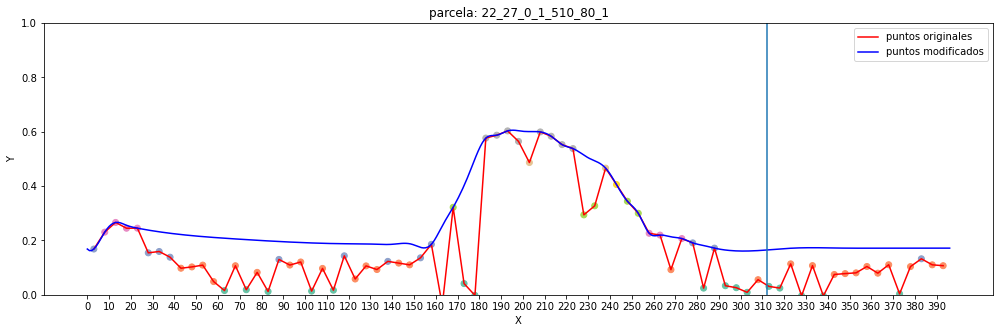

22_27_0_1_534_4_1
15347    2022-12-20
Name: Fecha de carga, dtype: object


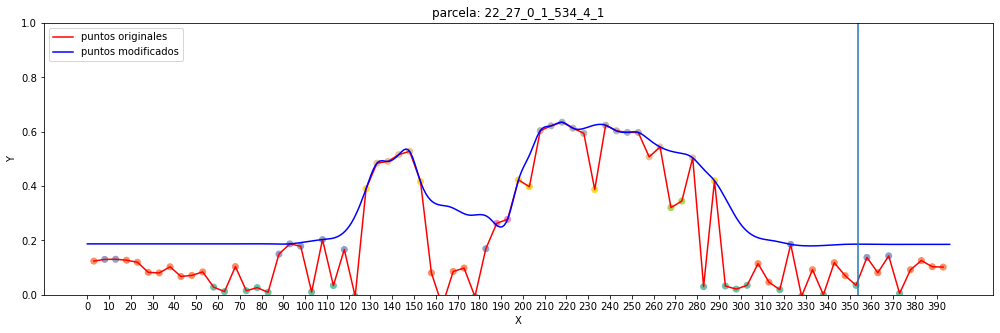

22_27_0_1_534_6_1
15348    2022-12-20
Name: Fecha de carga, dtype: object


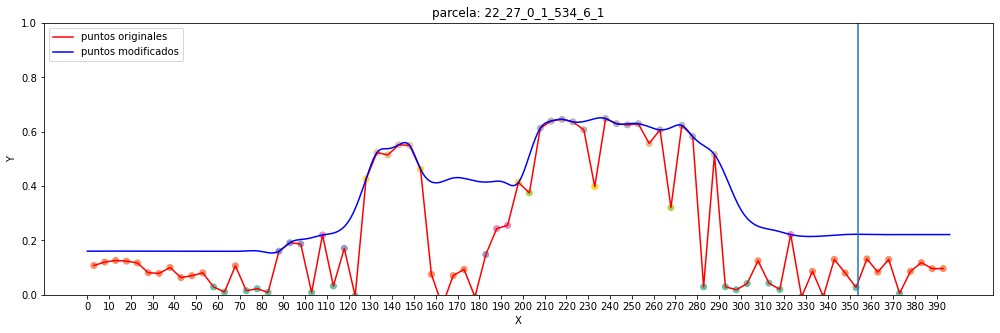

22_27_0_1_534_8_1
15349    2022-12-20
Name: Fecha de carga, dtype: object


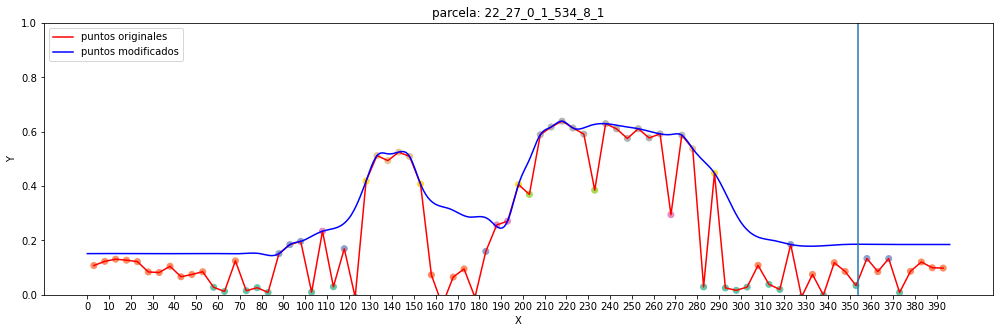

50_192_0_0_1_70_1
6094    2022-10-17
6095    2022-10-18
Name: Fecha de carga, dtype: object


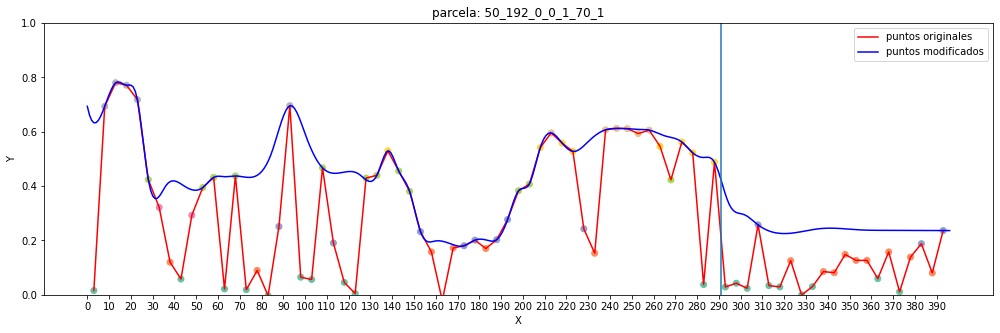

50_192_0_0_2_60_1
6096    2022-10-17
6097    2022-10-18
Name: Fecha de carga, dtype: object


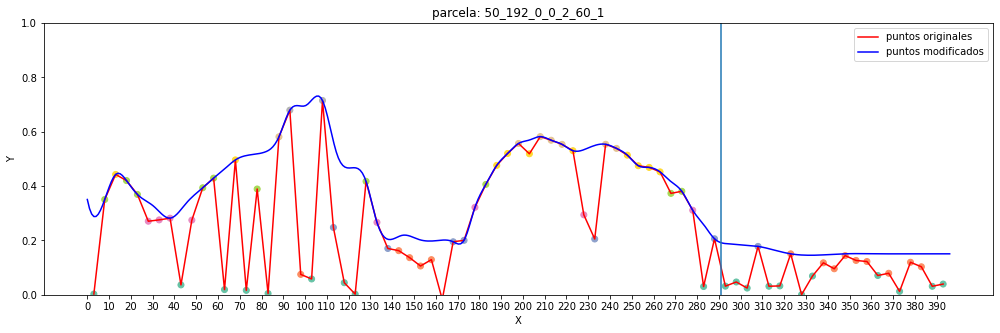

50_210_0_0_5_423_1
16691    2022-10-27
Name: Fecha de carga, dtype: object


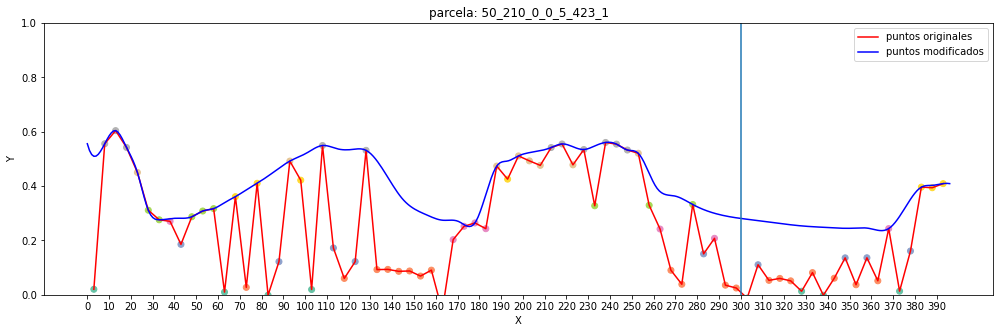

50_210_0_0_5_423_2
16692    2022-10-27
Name: Fecha de carga, dtype: object


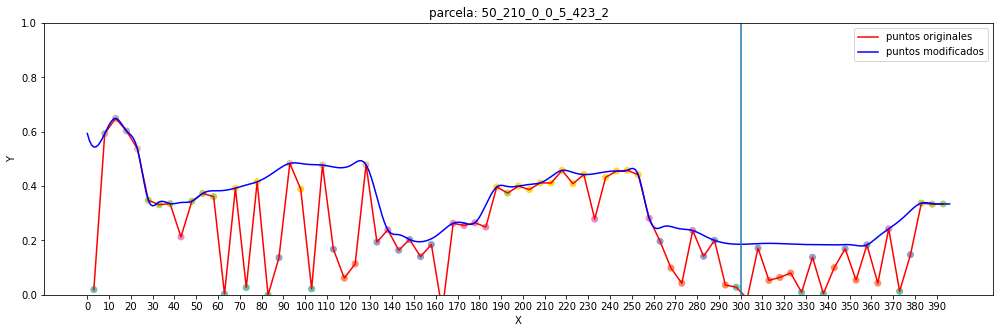

50_210_0_0_5_424_1
16693    2022-10-27
Name: Fecha de carga, dtype: object


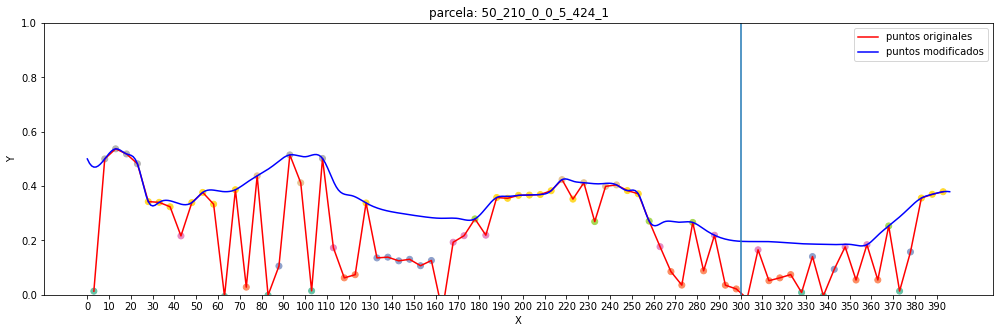

50_210_0_0_5_425_1
16694    2022-10-27
Name: Fecha de carga, dtype: object


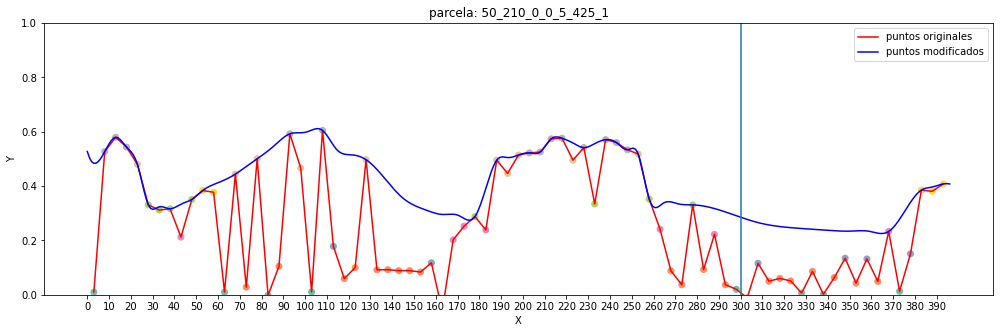

50_210_0_0_5_426_1
16695    2022-10-27
Name: Fecha de carga, dtype: object


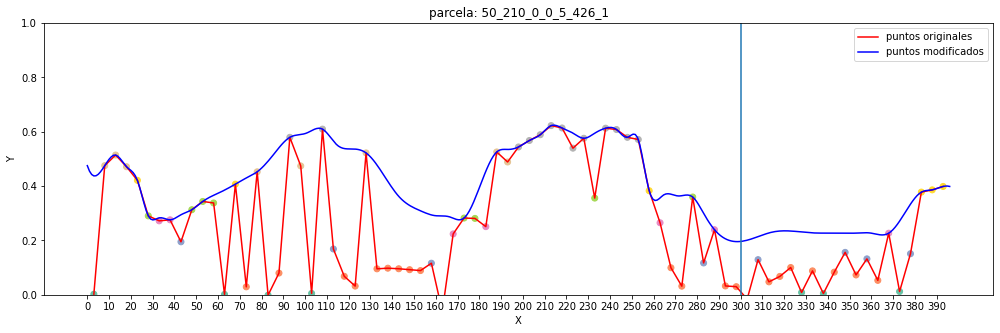

50_210_0_0_5_427_1
16696    2022-10-27
Name: Fecha de carga, dtype: object


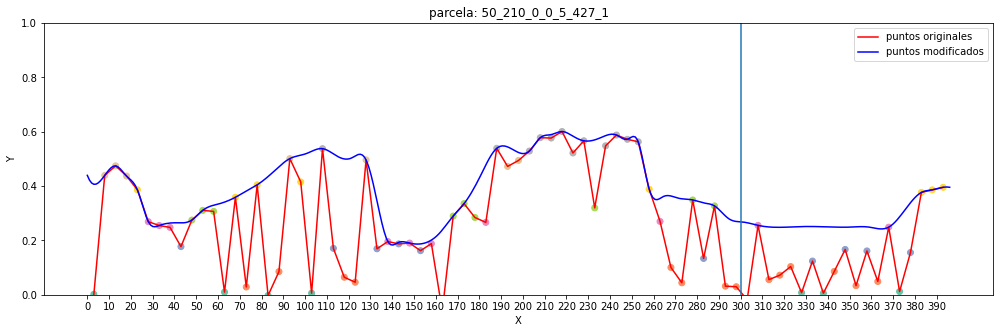

50_210_0_0_5_443_1
16697    2022-10-27
Name: Fecha de carga, dtype: object


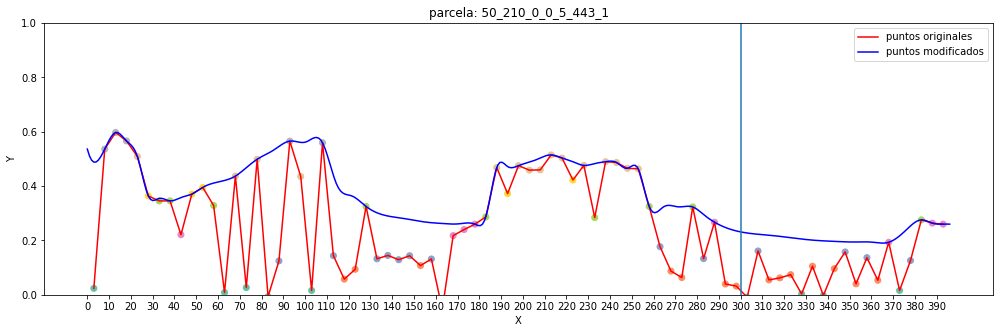

50_210_0_0_5_550_1
16698    2022-11-30
Name: Fecha de carga, dtype: object


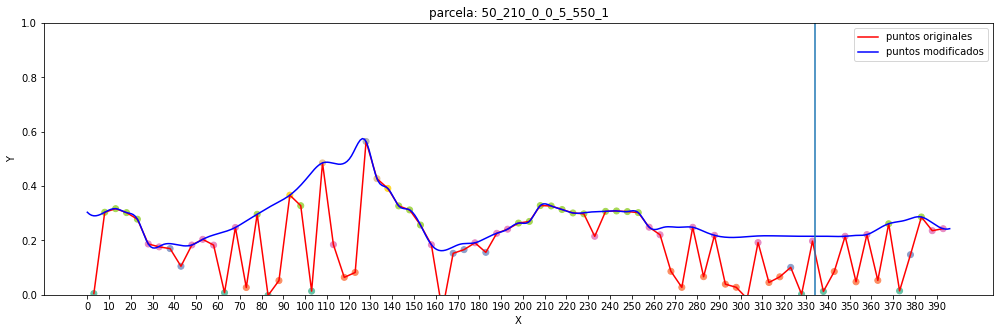

50_210_0_0_5_551_1
16699    2022-11-30
Name: Fecha de carga, dtype: object


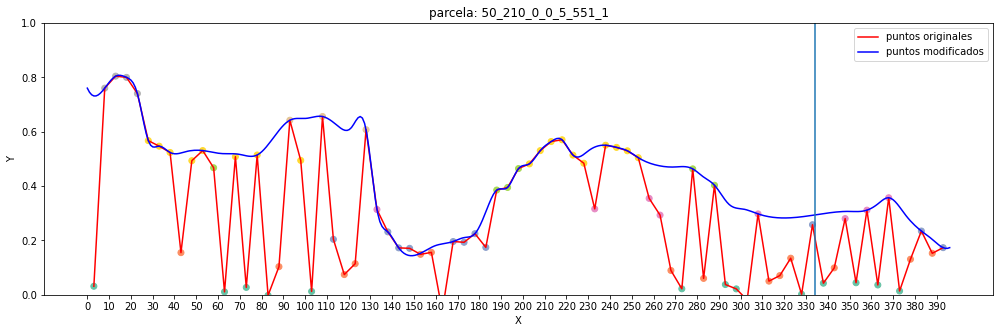

50_210_0_0_5_555_1
16700    2022-11-30
Name: Fecha de carga, dtype: object


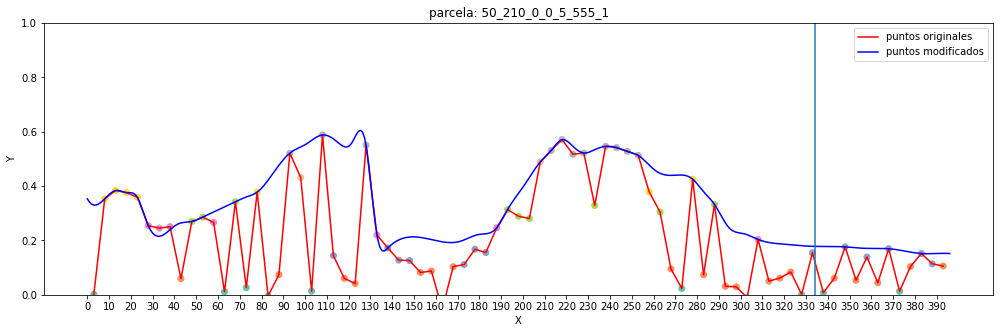

50_210_0_0_5_556_1
16701    2022-11-30
Name: Fecha de carga, dtype: object


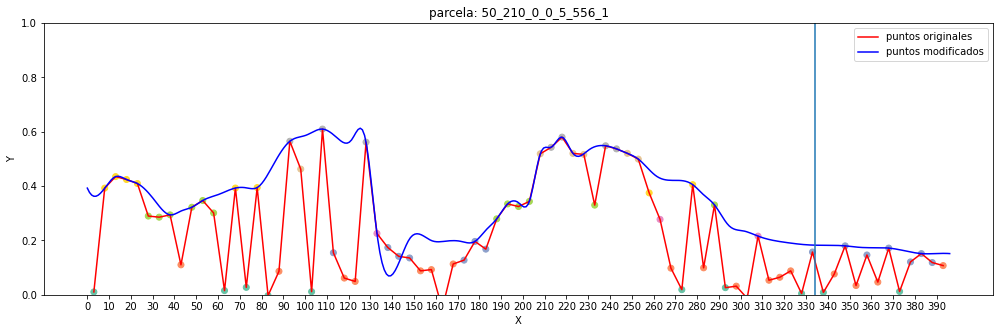

50_210_0_0_5_557_1
16702    2022-11-30
Name: Fecha de carga, dtype: object


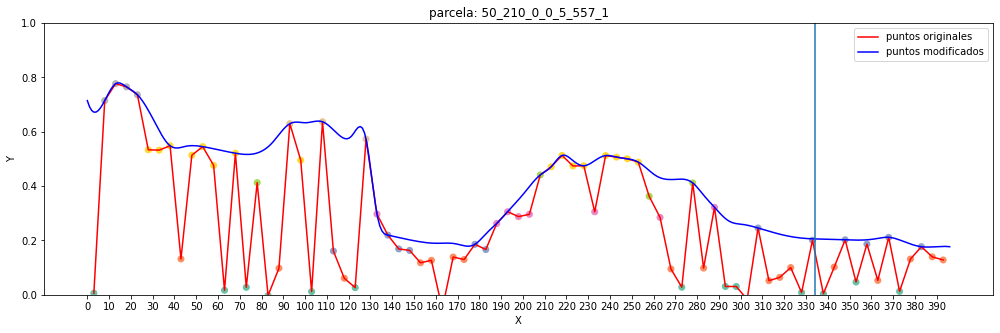

50_210_0_0_5_558_1
16703    2022-11-30
Name: Fecha de carga, dtype: object


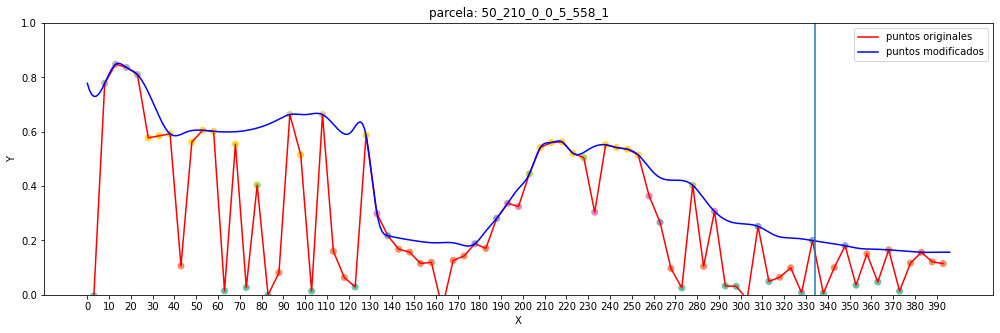

In [9]:
import pandas as pd
import numpy as np
# Leo el csv
df = pd.read_csv('requestsNdvi2022.csv')
df = df.loc[df['fecha'] != "not initialized"]
df['ndvi'] = df['ndvi'].astype(float)
df['fecha'] = df['fecha'].astype(str)
sorted_df = df.sort_values(by=["fecha","parcela"], ascending=True)

# Leo el fichero con las fechas de recepcion
dfFechas = pd.read_csv('PARCELAS-MAIZ-2022-2023-CON-FECHAS.csv')

# Creo el df final para guardar todos los datos
dfFinal = pd.DataFrame(columns=['parcela','fecha','ndvi','recogido'])


i = 0
for parcela in sorted_df['parcela'].unique():
    i += 1
    if i == 20:
        break
    dfParcela = sorted_df.loc[df['parcela'] == parcela]
    # Obtengo la ultima recepcion 
    fecha = dfFechas.loc[dfFechas['PAC'] == parcela.replace('_',':')].dropna()
    fecha = fecha['Fecha de carga']
    print(parcela)
    print(fecha)
    fecha = [int(str(i).replace('-','')) for i in list(fecha)]
    fecha = np.max(fecha)
    
    [y, aux] = algoritmo2022(dfParcela,fecha,True, parcela)
    
    # Creo el dataframe con los datos de cada dia
    dias = np.linspace(1,396,396)
    dfNew = pd.DataFrame(columns=['parcela', 'dia','ndvi','recogido'])
    recogido = np.zeros(396).astype(int)
    recogido[aux - 1] = 1
    dfNew = pd.DataFrame({'parcela': parcela, 'dia': dias.astype(int), 'ndvi': y, 'recogido': recogido})
    
    # Lo añado al dfFinal
    dfFinal = pd.concat([dfFinal, dfNew])
    dfFinal = dfFinal.reset_index(drop=True)


In [95]:
dfFinal

,parcela,fecha,ndvi,recogido
0,22_27_0_1_510_80_1,1,0.168405,0
1,22_27_0_1_510_80_1,2,0.162560,0
2,22_27_0_1_510_80_1,3,0.162972,0
3,22_27_0_1_510_80_1,4,0.168463,0
4,22_27_0_1_510_80_1,5,0.177854,0
...,...,...,...,...
465691,50_68_0_0_35_97_1,392,0.152530,0
465692,50_68_0_0_35_97_1,393,0.152532,0
465693,50_68_0_0_35_97_1,394,0.152538,0
465694,50_68_0_0_35_97_1,395,0.152549,0


En 'datos396_2022_23.csv' tenemos los datos de los 396 dias con ultima fecha de 'recogido'

Ahora convertiré esta informacion a la misma con la que he estado trabajando hasta ahora: 'parcela', 'dia', 'pendiente -15, -10 y -5', 'ndvi'

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('datos396_2022_23.csv')
dfNew = pd.DataFrame(columns=['parcela', 'dia', 'pendiente dia -15','pendiente dia -10', 'pendiente dia -5','ndvi', 'recogido'])

progreso = 1
total = len(df['parcela'].unique())
for parcela in df['parcela'].unique():
    dfAux = df.loc[df['parcela'] == parcela]
    fila_a_mirar = dfAux[(dfAux['parcela'] == parcela) & (dfAux['recogido'] == 1)]
    dia_recogida = fila_a_mirar.dia
    dias_dfNew = np.linspace(dia_recogida - 14, dia_recogida + 5, 20)
    if dias_dfNew[0] - 15 <= 0:
        total -= 1
        continue
    print(str(progreso) + "/" + str(total) )
    progreso += 1
    for dia in dias_dfNew.astype(int):
        diasPendientes = np.linspace(dia - 15, dia -5, 3)
        ndvi = dfAux.loc[dfAux['dia'] == dia[0]].ndvi
        valoresDiasPendientes = [((dfAux.loc[dfAux['dia'] == x[0]].ndvi) - float(ndvi))/ (float(dia[0] - x[0]))  for x in diasPendientes]
        # - float(ndvi))/float(dia[0] - x[0]) 
        if int(dia[0]) <= int(dia_recogida) and int(dia[0]) > int(dia_recogida) - 5:
            recogido = 1
        else:
            recogido = 0
        rowAux = pd.DataFrame({'parcela': parcela, 'dia': dia, 
                              'pendiente dia -15': valoresDiasPendientes[0].values, 
                              'pendiente dia -10': valoresDiasPendientes[1].values,
                              'pendiente dia -5': valoresDiasPendientes[2].values, 'ndvi': ndvi, 'recogido': recogido})
        dfNew = pd.concat([dfNew, rowAux])
        
dfNew.to_csv('datosEntrenables2022_2023.csv', index=False)

Despues obtendré los datos de temperatura, precipitacion y presion.

In [7]:
import pandas as pd
import numpy as np

df = pd.read_csv('datosEntrenables2022_2023.csv')
df['tmed'] = np.full(len(df), 'not initialized')
df['prec'] = np.full(len(df), 'not initialized')
df['precSum3'] = np.full(len(df), 'not initialized')
df['estacion'] = np.full(len(df), 'not initialized')

In [ ]:
import requests
import csv
import warnings
API_ENDPOINT3 = "http://maps.agroslab.com/AgroslabHttpServlet/AgroslabHttpServlet"
HEADERS = {'Content-Type': 'application/json'}
AUTH=('agroslabsecure','5rp6aLvVb6HU')
parcelasSinInformacion = list()
parcelasAObservar = df.loc[df['estacion'] == 'not initialized']
parcelasAObservar = parcelasAObservar['parcela'].unique()
progreso = 1
total= len(parcelasAObservar)

for parcela in parcelasAObservar:
    print(str(progreso) + '/' + str(total))
    print(parcela)
    datosParcela = df.loc[df['parcela'] == parcela]
    diaMin = str(datosParcela['dia'].iloc[0]-3) + "-01-2022"
    diaMax = str(datosParcela['dia'].iloc[len(datosParcela)-1]-1) + "-01-2022"
    
    recinto = parcela.replace("_","-")
    PARAMS = {"operation" : "aemetestacionesdwithin",
        "id": recinto,
        "distanceinkilometers": 100}
    
    r = requests.post(url = API_ENDPOINT3, headers=HEADERS, json= PARAMS, auth=AUTH, verify=False,timeout=60)
    
    cogerEstacion = 0
    hayInformacionEnParcela = True
    while True:
        #print(cogerEstacion)
        if cogerEstacion >= len(r.json()['aemet_estaciones']):
            parcelasSinInformacion.append(recinto.replace('-','_'))
            hayInformacionEnParcela = False
            break
        else:
            estacion = r.json()['aemet_estaciones'][cogerEstacion]['id']

            PARAMS2 = {"operation" : "aemetclimatologiadiaria",
              "initdate":diaMin,
              "enddate":diaMax,
              "idema" : estacion}

            r2 = requests.post(url = API_ENDPOINT3, headers=HEADERS, json= PARAMS2, auth=AUTH, verify=False,timeout=60)
            if "error" in r2.json():
                cogerEstacion = cogerEstacion + 1
            else:
                break
    
    if hayInformacionEnParcela:
        
        #print(recinto)
        #print(diaMin)
        #print(diaMax)
        #print(r.json())
        #print('-------------------------------------------------------------------------------------------')
        listaTmed = list()
        listaPrec = list()
        for info in r2.json():
            if "tmed" in info:
                listaTmed.append(info['tmed'])
            else:
                print("tmed")
                print(estacion)
                
            if "prec" in info:
                if info['prec'] == 'Ip':
                    listaPrec.append('0,0')
                else: 
                    listaPrec.append(info['prec'])
            else:
                print("prec")
                print(estacion)
                

        indices = datosParcela.index
        pos = 0
        if len(listaTmed) != 22 or len(listaPrec) != 22:
            continue
        progreso += 1
        for i in indices:
            df.at[i,'tmed'] = float(listaTmed[pos+ 2].replace(',','.'))
            if (listaPrec[pos+2] == 'Ip'):
                df.at[i,'prec'] = float(0)
            else:
                df.at[i,'prec'] = float(listaPrec[pos+2].replace(',','.'))
            
            df.at[i,'precSum3'] = float(listaPrec[pos].replace(',','.')) + float(listaPrec[pos+1].replace(',','.')) + float(listaPrec[pos+2].replace(',','.'))
            df.at[i,'estacion'] = estacion
            pos = pos + 1
    else:
        total -= 1


In [36]:
df.to_csv('datosEntrenables2022_2023.csv', index=False)

Ahora deberia repetir pero para encontrar las presiones

In [7]:
import pandas as pd
import numpy as np

df = pd.read_csv('datosEntrenables2022_2023.csv')
df['pres'] = np.full(len(df), 'not initialized')
df['estacionPres'] = np.full(len(df), 'not initialized')

In [8]:
df

,parcela,dia,pendiente dia -15,pendiente dia -10,pendiente dia -5,ndvi,recogido,tmed,prec,precSum3,estacion,pres,estacionPres
0,22_27_0_1_510_80_1,298,0.001351,0.001061,0.000689,0.161577,0,17.8,0.0,0.0,9898,not initialized,not initialized
1,22_27_0_1_510_80_1,299,0.001253,0.000915,0.000560,0.161262,0,17.9,0.0,0.0,9898,not initialized,not initialized
2,22_27_0_1_510_80_1,300,0.001138,0.000777,0.000438,0.161056,0,19.6,0.0,0.0,9898,not initialized,not initialized
3,22_27_0_1_510_80_1,301,0.001011,0.000644,0.000322,0.160952,0,22.0,0.0,0.0,9898,not initialized,not initialized
4,22_27_0_1_510_80_1,302,0.000878,0.000519,0.000213,0.160944,0,22.2,0.0,0.0,9898,not initialized,not initialized
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23435,50_68_0_0_35_97_1,357,-0.000339,-0.000288,-0.000150,0.153280,0,12.6,0.0,0.0,9434,not initialized,not initialized
23436,50_68_0_0_35_97_1,358,-0.000315,-0.000239,-0.000096,0.153282,0,14.7,0.0,0.0,9434,not initialized,not initialized
23437,50_68_0_0_35_97_1,359,-0.000285,-0.000189,-0.000049,0.153250,0,13.0,0.0,0.0,9434,not initialized,not initialized
23438,50_68_0_0_35_97_1,360,-0.000250,-0.000139,-0.000008,0.153191,0,9.6,0.0,0.0,9434,not initialized,not initialized


In [ ]:
import requests
import csv
import warnings
API_ENDPOINT3 = "http://maps.agroslab.com/AgroslabHttpServlet/AgroslabHttpServlet"
HEADERS = {'Content-Type': 'application/json'}
AUTH=('agroslabsecure','5rp6aLvVb6HU')
parcelasSinInformacion = list()
parcelasAObservar = df.loc[df['estacionPres'] == 'not initialized']
parcelasAObservar = parcelasAObservar['parcela'].unique()
progreso = 1
total= len(parcelasAObservar)

for parcela in parcelasAObservar:
    print(str(progreso) + '/' + str(total))
    print(parcela)
    datosParcela = df.loc[df['parcela'] == parcela]
    diaMin = str(datosParcela['dia'].iloc[0]-1) + "-01-2021"
    diaMax = str(datosParcela['dia'].iloc[len(datosParcela)-1]-1) + "-01-2021"
    
    recinto = parcela.replace("_","-")
    PARAMS = {"operation" : "aemetestacionesdwithin",
        "id": recinto,
        "distanceinkilometers": 100}
    
    r = requests.post(url = API_ENDPOINT3, headers=HEADERS, json= PARAMS, auth=AUTH, verify=False, timeout=60)
    
    cogerEstacion = 0
    hayInformacionEnParcela = True
    while True:
        #print(cogerEstacion)
        if cogerEstacion >= len(r.json()['aemet_estaciones']):
            parcelasSinInformacion.append(recinto.replace('-','_'))
            hayInformacionEnParcela = False
            break
        else:
            estacion = r.json()['aemet_estaciones'][cogerEstacion]['id']

            PARAMS2 = {"operation" : "aemetclimatologiadiaria",
              "initdate":diaMin,
              "enddate":diaMax,
              "idema" : estacion}

            r2 = requests.post(url = API_ENDPOINT3, headers=HEADERS, json= PARAMS2, auth=AUTH, verify=False, timeout=60)
            if "error" in r2.json():
                cogerEstacion = cogerEstacion + 1
            else:
                break
    
    if hayInformacionEnParcela:
        
        #print(recinto)
        #print(diaMin)
        #print(diaMax)
        #print(r.json())
        #print('-------------------------------------------------------------------------------------------')
        listaPres = list()
        for info in r2.json():
            if "presMax" in info and "presMin" in info:
                listaPres.append((float(info['presMax'].replace(',','.')) + float(info['presMin'].replace(',','.')))/2.0)
            else:
                print("pres")
                print(estacion)
                

        indices = datosParcela.index
        pos = 0
        if len(listaPres) != 20:
            total -= 1
            continue
        progreso += 1
        for i in indices:
            df.at[i,'pres'] = listaPres[pos]
            df.at[i,'estacionPres'] = estacion
            pos = pos + 1
    else:
        total -= 1
        


In [23]:
df.to_csv('datosEntrenables2022_2023.csv', index=False)

Ahora ya tengo todos los datos necesarios para hacer las pruebas

In [30]:
import pandas as pd
import numpy as np

df = pd.read_csv('datosEntrenables20230131-full-pres.csv')
parcelasAQuitar = df.loc[df['estacion'] == 'not initialized']['parcela'].unique()
parcelasAQuitar2 = df.loc[df['estacionPres'] == 'not initialized']['parcela'].unique()
df = df[~df['parcela'].isin(parcelasAQuitar)]
df = df[~df['parcela'].isin(parcelasAQuitar2)]
df = df.drop(columns=['Unnamed: 0','estacion','precSum3', 'estacionPres'])
df = quitarDatosMalos(df)

# Leer fichero 
dfFechas = pd.read_csv('PARCELAS-MAIZ-2022-2023-CON-FECHAS.csv')

# Obtengo el nº de dias de recepcion que tiene cada parcela
freq = dfFechas['PAC'].value_counts()
# Obtengo aquellas parcelas que tengan 5 o menos dias de recepcion
items = freq[freq==1].index
only_1_reception = dfFechas[dfFechas['PAC'].isin(items)]
# Adaptamos el formato de los datos
newPac = only_1_reception["PAC"].str.replace(":", "_")

df_test = pd.read_csv('datosEntrenables2022_2023.csv')
parcelasAQuitar = df_test.loc[df_test['estacion'] == 'not initialized']['parcela'].unique()
parcelasAQuitar2 = df_test.loc[df_test['estacionPres'] == 'not initialized']['parcela'].unique()
df_test = df_test[~df_test['parcela'].isin(parcelasAQuitar)]
df_test = df_test[~df_test['parcela'].isin(parcelasAQuitar2)]
df_test = df_test.drop(columns=['estacion','precSum3', 'estacionPres'])
df_test = quitarDatosMalos(df_test)
df_test = df_test[df_test['parcela'].isin(newPac)]

In [20]:
df

,parcela,dia,pendiente dia -15,pendiente dia -10,pendiente dia -5,ndvi,recogido,tmed,prec,pres
0,22_27_0_1_503_5017_1,292,0.013078,0.008582,-0.002236,0.456587,0,17.4,0.0,959.5
1,22_27_0_1_503_5017_1,293,0.011039,0.005081,-0.006042,0.467762,0,18.0,0.0,961.3499999999999
2,22_27_0_1_503_5017_1,294,0.008906,0.001723,-0.008617,0.478748,0,17.6,0.0,957.0
3,22_27_0_1_503_5017_1,295,0.006757,-0.001304,-0.009899,0.488632,0,15.5,0.0,953.3499999999999
4,22_27_0_1_503_5017_1,296,0.004652,-0.003832,-0.010032,0.496736,0,13.7,0.0,955.45
...,...,...,...,...,...,...,...,...,...,...
8155,50_224_0_2_18_50_1,289,0.005049,0.004059,0.004025,0.414865,0,16.8,0.0,988.5
8156,50_224_0_2_18_50_1,290,0.005029,0.004006,0.004614,0.409131,0,16.4,0.0,987.8
8157,50_224_0_2_18_50_1,291,0.004980,0.004131,0.005174,0.402966,0,17.8,0.2,989.25
8158,50_224_0_2_18_50_1,292,0.004917,0.004413,0.005670,0.396435,0,18.8,0.0,992.95


In [31]:
df_test

,parcela,dia,pendiente dia -15,pendiente dia -10,pendiente dia -5,ndvi,recogido,tmed,prec,pres
0,22_27_0_1_510_80_1,298,0.001351,0.001061,0.000689,0.161577,0,17.8,0.0,958.4
1,22_27_0_1_510_80_1,299,0.001253,0.000915,0.000560,0.161262,0,17.9,0.0,957.2
2,22_27_0_1_510_80_1,300,0.001138,0.000777,0.000438,0.161056,0,19.6,0.0,959.05
3,22_27_0_1_510_80_1,301,0.001011,0.000644,0.000322,0.160952,0,22.0,0.0,957.45
4,22_27_0_1_510_80_1,302,0.000878,0.000519,0.000213,0.160944,0,22.2,0.0,953.05
...,...,...,...,...,...,...,...,...,...,...
23115,50_283_0_0_2_5_1,301,0.000050,-0.000257,-0.000111,0.208428,0,21.3,0.0,991.5
23116,50_283_0_0_2_5_1,302,-0.000151,-0.000201,-0.000063,0.208403,0,22.0,0.0,986.45
23117,50_283_0_0_2_5_1,303,-0.000233,-0.000148,-0.000019,0.208341,0,20.8,0.0,980.3
23118,50_283_0_0_2_5_1,304,-0.000234,-0.000098,0.000022,0.208245,0,17.4,0.6,976.7


In [24]:
import os
import joblib
from sklearn.model_selection import KFold
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score, accuracy_score
def probarMejorModelo_3(best_model, split, data_test, n_splits = 10, umbral=0.5, random_state = 33, normalizacion=[0,1]):
    from sklearn.metrics import classification_report
    parcelas = df['parcela'].unique() # obtenemos las parcelas

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    i = 0
    for train_index, test_index in kf.split(parcelas): # separamos los datos de train y test segun la parcela
        i += 1
        if i != split:
            continue
        # obtenemos las parcelas de train y test
        parcelasTrain = parcelas[train_index]
        parcelasTest = parcelas[test_index]

        # separamos en 2 df segun las parcelas de train o test
        df_train = df[df['parcela'].isin(parcelasTrain)]
        df_test = data_test
        

        # preparo la normalizacion
        scaler = MinMaxScaler(feature_range=(normalizacion[0], normalizacion[1]))

        # arreglamos undersampling en los datos de train
        smote = SMOTE(sampling_strategy=1, random_state=random_state)
        X_train,y_train = smote.fit_resample(df_train.drop(columns=['recogido','parcela','dia','prec']), df_train['recogido'])
        X_train = scaler.fit_transform(X_train)
        X_train = pd.DataFrame(X_train, columns=df_train.drop(columns=['recogido','parcela','dia','prec']).columns)

        # preparamos datos de test
        X_test, y_test = df_test.drop(columns=['recogido','parcela','dia','prec']), df_test['recogido']
        X_test = scaler.transform(X_test)
        X_test = pd.DataFrame(X_test, columns=df_test.drop(columns=['recogido','parcela','dia','prec']).columns)
        
        dtrain = X_train
        dtest = X_test
        
        model = best_model
            
        if hasattr(model, 'predict_proba'):
            y_pred = model.predict_proba(dtest)[:,1]
            y_train_pred = model.predict_proba(dtrain)[:,1]
        else:
            y_pred = model.predict(dtest)
            y_train_pred = model.predict(dtrain)
            
        y_pred_round = round_threshold(y_pred, umbral)
        

        # Suponiendo que 'y_true' son los valores verdaderos y 'y_pred' son los valores predichos
        report = classification_report(y_test, y_pred_round)

        # Imprimir el informe de clasificación
        print(report)

        mostrarCurvaRoc(y_train, y_train_pred, y_test, y_pred)
        
        # Calcular el numero de parcelas de test que acierta
        X_test2 = X_test
        X_test2['parcela'] = df_test['parcela'].values
        X_test2['recogido'] = df_test['recogido'].values
        X_test2['dia'] = df_test['dia'].values
        [parcelasAObservar, parcelasSinResultado] = parcelasConAciertos(X_test2, model, umbral, verbose = 0)
        dataframeAux = X_test2
        dataframeDias = X_test2.loc[X_test2["recogido"] == 1]
        
        score = roc_auc_score(y_test, y_pred)
        print(f'Test ROC AUC: {score}')
        accuracy = accuracy_score(y_test, y_pred_round)
        
        # Calcular el exito
        [mini,maxi,promedi] = exito(X_test2,model, funcionExito, verbose =0)
        print("Exito min: ", mini, "\nExito max: ", maxi, "\nExito promedio: ",promedi)
        print("Exito * accuracy = ", promedi*accuracy)
        print("Exito * accuracy / (Exito + accuracy) = ", promedi*accuracy / (promedi + accuracy))
        print("="*50)

              precision    recall  f1-score   support

           0       0.75      0.89      0.81      8070
           1       0.22      0.09      0.13      2690

    accuracy                           0.69     10760
   macro avg       0.48      0.49      0.47     10760
weighted avg       0.61      0.69      0.64     10760



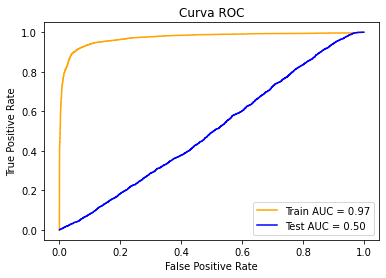

Parcelas con acierto:  170 de 538   31.60%
Test ROC AUC: 0.503060488384627
Exito min:  0.02728634075280498 
Exito max:  0.9840821352530935 
Exito promedio:  0.4602684430754497
Exito * accuracy =  0.31696925308448715
Exito * accuracy / (Exito + accuracy) =  0.2758820910268303


In [33]:
carpeta = "OptunaShap2-LGBM-20230315"
num_trial_best = 276
# carga el mejor modelo
best_model_file = os.path.join(carpeta, f"model_trial_{num_trial_best}.joblib")
params, score, best_model = joblib.load(best_model_file)

probarMejorModelo_3(best_model, umbral=0.6, split=1, data_test=df_test)